# DÉTECTEZ LES BAD BUZZ GRACE AU DEEP LEARNING

<img src="logo_air_paradis.png" alt="logo_air_paradis" width="400" class="center"/>

# PRÉAMBULE

## 0.1) Projet de l'entreprise *Air Paradis*

*Air Paradis* souhaite pouvoir disposer d'un **produit IA** permettant d'**anticiper les bad buzz** sur les **réseaux sociaux**.

L'entreprise a missionné *MIC* (*Marketing Intelligence Consulting*) pour l'accompagner dans le développement du ce projet, avec les éléments de mission suivants :
- **Préparer un prototype** de produit IA permettant de **prédire le sentiment associé à un tweet**
- **Préparer un support** de présentation **vulgarisant la méthodologie** utilisée pour l'approche "modèle sur mesure avancé"

## 0.2) Proposition de *MIC*

Afin de **répondre au mieux à *Air Paradis*** et permettre une **meilleure évangélisation des connaissances acquises**, nous avons décomposé la mission de la manière suivante :
- Tests de plusieurs approches de **modélisation** :
    - **"Modèle sur mesure simple"** : développement rapide d'un modèle **classique** de machine learning (régression logistique par exemple), qui servira de base de comparaison
    - **"Modèle sur mesure avancé"** : développement plus poussé d'un modèle de Deep Learning.<br>
      Tests de :
        - plusieurs modèles
        - plusieurs **word embeddings**
    - de l'apport d'un modèle basé sur des transformers : ***BERT*** (*Bidirectional Encoder Representation from Transformers*)
- Élaboration du prototype en suivant la **démarche MLOps** :
    - présentation synthétique des **principes du MLOps** et de ses apports
    - utilisation de **`MLFlow`** pour :
        - assurer les **gestion des expérimentations** (tracking, reporting)
        - centraliser le **stockage des modèles**
        - tester le **serving** proposé
    - mettre en oeuvre un **pipeline de déploiement continu** du modèle gagnant :
        - via une **API** : Git + GitHub + Azure WebApp
        - intégrant des **tests unitaires**
        - **limitant les coûts** :
            - version **gratuite** d'Azure WebApp
            - limiter la taille du modèle gagnant via **TensorFlow Lite**
- Rédiger un **article de blog** sur la démarche de modélisation utilisée :
    - modèles
    - métriques
    - interprétabilité
    - démarche MLOps
- Préparer **une présentation** expliquant la démarche avec un **travail de vulgarisation**

## 0.3) Imports des librairies

In [6]:
# for memory management
import gc

# file and directory management
import os
import shutil
# to make saves
from joblib import dump, load
# to inspect functions
import inspect

# data manipulation
import pandas as pd  # to manipulate the dataset with dataframes
import numpy as np  # for statistics and calculations

# data viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")
from wordcloud import WordCloud

# custom functions
import myFunctions as mf
%load_ext autoreload
    
%autoreload 2

# nlp with nltk
import nltk
# stopwords management
from nltk.corpus import stopwords
nltk.download('stopwords')
# nlp with spacy
import spacy
nlp = spacy.load("en_core_web_sm")
# regular expressions
import re
# counter
from collections import Counter

# scikit learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, classification_report, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# keras and tensorflow
import tensorflow as tf
import keras
from keras import Sequential
from keras import Input
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.callbacks import EarlyStopping
import tensorflow_hub


# tracking
import mlflow

import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cleme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 0.4) Création d'un dossier de stockage

In [ ]:
# create folder for saving
if not os.path.isdir("mySaves"):
    os.mkdir("mySaves")

# PARTIE 0 - LA DÉMARCHE MLOPS

## P0.I) Qu'est-ce que le MLOps ?

**MLOps** est un ensemble de pratiques qui **combine** les techniques de développement logiciel (**DevOps**) et d’apprentissage automatique (**Machine Learning**) pour optimiser et automatiser le cycle de vie de l’apprentissage machine. Le but de MLOps est d’aider les organisations à **construire, déployer et gérer** des modèles d’apprentissage machine en environnement de production **plus efficacement et plus rapidement**. 

Voici quelques principes clés du MLOps :
- Développement du pipeline de traitement des données :
    - cela comprend le travail préliminaire de collecte des données, d'exploration, etc.
    - nettoyage, traitements, feature engineering, etc
- Développement du pipeline de modélisation :
    - entraînement de différents modèles, avec différentes combinaisons d'hyperparamètres
    - évaluation et sélection du meilleur modèle
- Intégration continue du pipeline général :
    - utilisation d'une platefrome de développement collaboratif et de gestion de version
    - pour travailler sur le code source et suivre ses modifications
    - tests unitaires, tests de performance, etc.
- Déploiement continue du pipeline général :
    - automatisation totale du pipeline
    - y compris collecte, préparation, recherche d'hyperparamètres
- Tracking :
    - utilisation de solutions (comme `MLflow` que nous utiliserons ici) pour faire un suivi automatisé des différents expérimentations conduites avec le pipeline
    - enregistrement des paramètres de préparation, du type de modèle, des hyperparamètres et enfin des mesures d'évaluation associées
- Enregistrement des modèles :
    - chaque version du modèle est consignée
    - avec toutes les données/informations ayant servi à la construire
- Déploiement continue du modèle
    - mettre en place un serveur ou utiliser une plateform cloud
    - y installer les dépendances nécessaires pour utiliser le modèle
    - créer une API permettant d'accéder au modèle et d'optenir des prédictions
- Monitoring :
    - suivi des performances du modèle en production
    - envoi d'alertes si le modèle n'est plus aussi bon sur les données en temps réel
- Entraînement continue :
    - en cas de dégradation de la performance (alerte)
    - mise à jour du modèle en utilisant le pipeline général automatisé
- Gouvernance et Conformité :
    - respecter les règlements et exigences relatifs à la confidentialité des données,
    - ainsi qu'à la sécurité et à l’utilisation éthique de l’IA
- Scalabilité :
    - absorber les évolutions de la demande
    - système distribué pour permettre les mutations des solutions logiciels et matériels 
- Collaboration et documentation :
    - documenter l'ensemble du cycle de vie du produit IA (le code, la donnée, l'architecture)
    - communiquer / évangéliser pour améliorer les performances et détecter les problèmes
 
Pour chacune de ces étapes, des solutions logiciels existent et permettent d'implémenter des projets IA avec une meilleure efficacité ainsi qu'une plus grand fiabilité. Ils ne sont pas tous obligatoires et dépendent des besoins de chaque projet.


## P0.II) Et pour notre projet ?

### P0.II.1) Utilisation de `MLFlow`

Pour réaliser la partie tracking de notre projet, nous utiliserons `MLFlow`.

#### Qu'est-ce qu'`MLFlow` ?

`MLFlow` permet de gérer le cycle de développement des modèles IA :
- création d'***experiment*s** dans lesquelles il est possible d'exécuter différents tests sur un même projet de modèle
- au sein d'une de ces *experiments*, il est possible d'exécuter différents ***run*s**, permettant de tester différents types de modèle, différents paramètres, différentes préparations de données, etc.
- pour chaque *run* il est possible d'effectuer le ***tracking*** :
    - des **données** utilisées
    - des **paramètres** utilisés
    - de **métriques** d'évaluation
- pour chaque *run*, il est possible d'enregistrer le **modèle** dans un ***Model Registry***
- gestion personnalisée des modèles, avec du **versionning** et avec possibilité de renseigner des *tags* et des *alias* pour une meilleure navigation
- **visualisation et comparaison des résultats** via l'ui de `MLFlow` pour sélectionner le meilleur modèle
- mise à disposition d'un modèle, et de sa capacité à prédire, dans un environnement de production via des fonctionnalités de **serving**

#### `MLFlow` dans notre cas

Pour notre projet, nous utiliserons MLFlow pour :
- tracker les hyperparamètres de nos différents modèles
- tracker les métriques
- enregistrer les modèles que nous souhaitons conserver
- charger le modèle gagnant et faire des prédictions
- tester le service de *serving*

In [36]:
mlflow.get_tracking_uri()

'file:///c:/Users/cleme/OneDrive/Documents/8.%20TRAVAIL%20CLEMENT/2.3.%20Rec%20Data/1.%20OC/2.%20Projets/2.7%20Detectez%20Bad%20Buzz%20Deep%20Learning/mlruns'

In [37]:
# create experiments
if not mlflow.get_experiment_by_name("sentiment_analysis") :
    mlflow.create_experiment("sentiment_analysis")

In [38]:
mlflow.get_experiment_by_name("sentiment_analysis").experiment_id

'931894627455945656'

### P0.II.2) Utilisation de `GitHub`

Nous utiliserons `GitHub` gérer l'intégration de notre code :
- création d'un *repository* dédié sur la plateforme
- développement en local du projet
- création de *commit*s pour synchroniser les changements effectués sur les différents fichiers du projet
- mises à jour du *repository* distant

# PARTIE 1 - NOS DONNÉES

## P1.I) Charger les données

Nous ne disposons pas de données clients *Air Paradis*, nous utilisons donc des données Open Source : https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download

Ce dataset comporte les colonnes suivantes :

- `target` : la polarité du tweet (0 = négatif, 2 = neutre, 4 = positif). C'est cette information que *Air Paradis* souhaite prédire.
- `ids` : l'identifiant du tweet
- `date` : la date du tweet
- `flag` : La requête. S'il n'y a pas de requête, alors prend la valeur : *NO_QUERY*
- `user` : l'utilisateur
- `text` : le texte du tweet

Pour notre travail nous n'aurons pas besoin de toutes ces colonnes. Nous ne garderons que `target` et `text` : 

In [ ]:
# load "Sentiment140" tweets dataset
rawData = pd.read_csv(
    filepath_or_buffer="dataset/training.1600000.processed.noemoticon.csv", 
    encoding="ISO-8859-1",
    usecols=[0,5],
    names=["target","text"]
)

In [ ]:
rawData

## P1.II) Exploration

### P1.II.1) Les valeurs manquantes

In [ ]:
# search for missing values
rawData.isna().sum()

Nous n'avons pas de valeurs manquantes.

### P1.II.2) Les doublons

In [ ]:
# search for duplicated tweets
# first create a mask
mask = rawData["text"].duplicated(keep=False)
# filter
duplicates = rawData.loc[mask].sort_values(by="text")
duplicates

Nous avons bien des tweets en double, ce qui en soit n'est pas très grâve. Nous voyons par contre un problème sur les deux dernières lignes : le même tweet n'est pas associé au même sentiment ...

Il nous faudra donc :
- **supprimer les doublons**
- dans le **cas d'incohérence au niveau de la polarité**, supprimer l'**original** **et** les **doublons**

### P1.II.3) La `target`

Nous pouvons regarder la distribution de la target :

In [ ]:
# plot the distribution of "target"
sns.countplot(data=rawData,x="target")
# add title
plt.title("Distribution of 'target'")
plt.show()

Ce que nous pouvons en conclure :
- la classe '2=neutral' n'est pas du tout représentée
- Nous sommes face à une problème de classification équilibrée

Afin de revenir à des notations plus typiques, nous allons changer les étiquettes de la `target` :
- 0 : tweet positif
- 1 : tweet négatif, **classe que l'on cherche à détecter avec précision pour anticiper les bd buzz**

In [ ]:
rawData["target"] = rawData["target"].replace(to_replace={4:0,0:1})

### P1.II.4) Les mots les plus fréquents

Créons tout d'abord un `str`  avec tout les corpus :

In [ ]:
rawCorpus = "".join(rawData["text"].values)

Procédons à une première tokenisation simple, en ne gardant que les caractères alphanumériques :

In [ ]:
# create a tokenizer using nltk RegexpTokenizer
# regex pattern : only alphanumerical
tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
rawTokens = tokenizer.tokenize(rawCorpus)
# lower case
rawTokens = [token.lower() for token in rawTokens]

Retirons maintenant les *stopwords* (mot-vides) :

In [ ]:
# create a set of stop-words
stop_words = set(stopwords.words('english'))
# remove them from our tokenized corpus
rawTokensNoStop = [token for token in rawTokens if token not in stop_words]

Nous pouvons regarder les mots les plus fréquents dans notre corpus :

In [ ]:
# create of folder to save some plots
if not os.path.isdir("mySaves/plots"):
    os.mkdir("mySaves/plots")

In [ ]:

# number of words to plot
N = 50
# create figure
fig, (axAll,axNoStop) = plt.subplots(nrows=1,ncols=2,figsize = (14,0.2*N))

for tokens, ax in zip([rawTokens,rawTokensNoStop],[axAll,axNoStop]) :
    # use Counter function to find most common tokens
    rawFreq = Counter(tokens)
    
    # put the most frequent in a dataframe
    N = 50
    rawFreqDf = pd.DataFrame(rawFreq.most_common(N), columns=["token","freq"])
    # store these tokens in an array
    top50 = rawFreqDf["token"].values
    
    # plot
    sns.barplot(data=rawFreqDf, x="freq", y="token", ax=ax)

# titles
fig.suptitle("tweets - Most frequent words")
axAll.set_title("all tokens")
axNoStop.set_title("without stopwords")

plt.show()

Ce que l'on peut en retenir :
- Retirer les **stopwords** dépendra de la méthode de modélisation utilisée :
    - Notre **modèle simple** sera basée sur une représentation en **bag-of-words**, il sera donc opportun de les gérer
    - Notre **modèle avancé** sera basée sur un réseau de neuronnes prenant en compte le context. Les retirer ne serait pas productif (exemple : "I am not writing a negative tweet" devient "writing negative tweet").
- Des tokens associés à des **url** ressortent ("http", "com"). Il faudra les traiter.
- Il y a des **codes HTML** : "quot" pour *"*, "amp" pour *&*

### P1.II.5) Et les mots les plus fréquents en fonction de la `target` ?

On peut regarder ce que cela donne par classe de la `target`, tout d'abord via un `wordcloud` :

In [ ]:
# filter our dataset on each value of "target", then plot a wordcloud of the most frequent words, 
# number of words to plot
N = 50
# create figure
fig, (axPos, axNeg) = plt.subplots(nrows=1,ncols=2,figsize = (14,8))

for pol,ax,name in zip(
    [0,1],
    [axPos, axNeg],
    ["wordcloudPos.jpg","wordcloudNeg.jpg"]
    ) :
    
    if name not in os.listdir("mySaves/plots") :
    
        # filter
        rawDataPol = rawData[rawData["target"]==pol]
        # create global corpus
        rawCorpusPol = "".join(rawDataPol["text"].values)
        # tokenize
        rawTokensPol = tokenizer.tokenize(rawCorpusPol)
        # lower case
        rawTokensPol = [token.lower() for token in rawTokensPol]
        # keep words in top50 list
        rawTokensPol = [token for token in rawTokensPol if token in set(top50)]
        # use Counter
        freqsPol = Counter(rawTokensPol).most_common(N)
        # create wordcloud instance
        wc = WordCloud(
            width = 400,
            height = 400,
            background_color="white",
            colormap="cividis",
            random_state=16
            )
        # fit
        wcFitted = wc.fit_words(dict(freqsPol))
        # save
        wcFitted.to_file("mySaves/plots/"+name)

    else :
        wcFitted = plt.imread("mySaves/plots/"+name)

        
    # plot the first N words
    ax.imshow(wcFitted)
    # remove axis
    ax.axis("off")
    
# titles
fig.suptitle("tweets - Most frequent words, by sentiment :")
axPos.set_title("Positive")
axNeg.set_title("Negative")

plt.show()

Ce n'est pas tout à fait clair, bien que très visuel... Regardons ce que cela donne avec un barplot :

In [ ]:
# initiate a count dataframe
freqDf = pd.DataFrame(columns=["token","freq","target"])
# create figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize = (14,0.3*N))

# create palette
sentimentPalette = {0:"green",1:"red"}

if "wordsFreqsByTarget.png" not in os.listdir("mySaves/plots") :

    for pol in [0,1]:
           
        # filter
        rawDataPol = rawData[rawData["target"]==pol]
        # create global corpus
        rawCorpusPol = "".join(rawDataPol["text"].values)
        # tokenize
        rawTokensPol = tokenizer.tokenize(rawCorpusPol)
        # lower case
        rawTokensPol = [token.lower() for token in rawTokensPol]
        # keep words in top50 list
        rawTokensPol = [token for token in rawTokensPol if token in set(top50)]
        # use Counter
        freqsPol = Counter(rawTokensPol)
        # put the most frequent in a dataframe
        freqDfPol = pd.DataFrame(freqsPol.most_common(N), columns=["token","freq"])
        # add a target column
        freqDfPol["target"] = pol
        # concat with main df
        freqDf = pd.concat([freqDf, freqDfPol])
    
    # plot
    sns.barplot(data=freqDf, x="freq", y="token", hue="target", ax=ax, palette=sentimentPalette, order=top50)
    # titles
    plt.title("tweets - Most frequent words, by sentiment")
    # save figure
    fig.savefig("mySaves/plots/wordsFreqsByTarget.png")
    
    plt.show()

else :
    im = plt.imread("mySaves/plots/wordsFreqsByTarget.png")
    plt.imshow(im)
    plt.axis(False)
    plt.show()

Ce que l'on peut en retenir :
- on retrouve des associations **logiques** :
    - "good", "love", "lol", "thanks", "great", "haha", "fun", etc. plus présents dans les **tweets positifs**
    - "work", "miss", "need", "sad", "feel", etc. plus présents dans les **tweets négatifs**
- il semble que les **url** ("http", "com") ou les **citations** (code HTML "quot") soient plus utilisés dans un **contexte positif**

### P1.II.6) La longueur des tweets

Nous pouvons nous intéresser à la longueur des tweets :

In [ ]:
# create a column with the size of tweets
rawData["NEW_len_text"] = rawData["text"].apply(lambda x : len(x))

On peut regarder la distribution de `NEW_len_text`, avec ou sans prise en compte de la `target` :

In [ ]:
# plot the distribution of tweets lengths

# create figure
fig, (axBar,axHist) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(14,7),
    height_ratios=(.25,.75),
    sharex=True
)
# plot histogram
sns.histplot(data=rawData, x="NEW_len_text", ax=axHist)
# plot box plot with hue on target
sns.boxplot(data=rawData, x="NEW_len_text", ax=axBar, hue="target", palette=sentimentPalette)

# titles
fig.suptitle("Distribution of lengths of tweets")
axBar.set_title("box plot, by 'target'")
axHist.set_title("histogram")

plt.show()

Ce que l'on peut en retenir :
- la longueur du tweet ne semble **pas** avoir d'**impact** sur la `target`
- la plupart des tweets sont **sous 140 caractères**, ce qui correspond à l'ancienne limite d'avant 2017
- il y a des tweets très courts...

Regardons à quoi correspondent ces tweets :

In [ ]:
# display someof tweets with less than 
# display some examples of tweets with more than 140 characters
for nChars in [0,140,160,180,200] :
    # create a filter mask
    mask = (rawData["NEW_len_text"] > nChars) &  (rawData["NEW_len_text"] < nChars+20)
    # print some examples
    print("For tweets in ["+str(nChars)+", "+str(nChars+20)+"] characters :")
    print("")
    samp = rawData.loc[mask, "text"].sample(10, random_state=16).apply(lambda x : print("--> "+x))
    print("-"*30)
    print("")

Ce que l'on peut en retenir :
- Les tweets **courts** sont parfois composés seulement d'une **mention** "@USER"...
- Il semble que les **dépassements** proviennent :
    - des **mentions** "@USER" en début de tweet (qui ne comptent pas dans le décompte)
    - de **codes HTML** comme `&quot;` ou `&amp;` (qui ne comptent pas dans le décompte)
    - de tweets rédigés avec **caractères autres** que ASCII "imprimables"

### P1.II.7) Les tweets contenant seulement une mention

Regardons ces tweets :

In [ ]:
test= "@e_bookpushers @Has_Bookpushers    "
bool(re.search(r'^(@\w+\s*)+$', test))

In [ ]:
# create a mask with tweets cointaining only mentions
# (?: ...) for non-capturing groups, to get rid of pandas warning
mask = rawData["text"].str.contains(r'^(?:@\w+\s*)+$', regex=True)

# filter our dataframe
onlyMentionsTweets = rawData.loc[mask]
# sort by lenth and display
display(onlyMentionsTweets.sort_values("NEW_len_text"))

Nous pourrons nous en séparer ...

### P1.II.7) Les tweets contenant des codes ASCII non communs

Regardons les tweets contenant au moins un caractère non "imprimable" (https://www.ascii-code.com/fr) :

In [ ]:
# create a mask with tweets cointaining non "printable" ASCII codes
mask = rawData["text"].str.contains(r"[^\u0000-\u007F]+")

# filter our dataframe
nonPrintableTweets = rawData.loc[mask]
# sort by lenth and display
display(nonPrintableTweets.sort_values("NEW_len_text"))

On peut afficher la liste des caractères uniques :
- pour ces tweets contenant des caractères non "imprimables" :

In [ ]:
# find the unique characters in nonPrintableTweets

# first put all tweets in a single string
nonPrintableTweetsCorpus = "".join(nonPrintableTweets["text"].values)
# use set() to catch uniques, then put them in one string
lst = list(set(nonPrintableTweetsCorpus))
lst.sort()
" ".join(lst)

- pour les tweets "normaux" :

In [ ]:
# find the unique characters in nonPrintableTweets

# first apply the opposite of our mask
printableTweets = rawData.loc[~mask]
# then put all tweets in a single string
printableTweetsCorpus = "".join(printableTweets["text"].values)
# use set() to catch uniques, then put them in one string
lst = list(set(printableTweetsCorpus))
lst.sort()
" ".join(lst)

Nous pourrons **nous séparer des 14538 tweets concernés** par des caractères non "imprimables".

### P1.II.8) Les codes HTML caractères spéciaux et les tags

Recherchons les caractère spéciaux HTML (comme `&quot;` que nous avons repéré auparavant) :

In [ ]:
set(mf.findHTML(rawCorpus))

Nous les supprimerons.

### P1.II.9) Les url

Recherchons les sites web :

In [ ]:
# use custom function findURL
# save the result
if "urls.joblib" not in os.listdir("mySaves/lists") :
    urls = mf.findURL(rawCorpus)
    dump(urls, "mySaves/lists/urls.joblib")

else :
    urls = load("mySaves/lists/urls.joblib")

In [ ]:
# use custom function plotWordCloud to plot some examples on a wordcloud
mf.plotWordCloud(
    listOfStrings=urls,
    nWordsToPLot=250,
    savingFolderAndName = ("mySaves/plots", "urlsWordCloud.jpg")
)

Nous les remplacerons par : "URL".

### P1.II.10) Les adresses mail

In [ ]:
# use custom function findEmails
# save the result
if "emails.joblib" not in os.listdir("mySaves/lists") :
    emails = mf.findEmails(rawCorpus)
    dump(emails, "mySaves/lists/emails.joblib")

else :
    emails = load("mySaves/lists/emails.joblib")

In [ ]:
# use custom function plotWordCloud to plot some examples on a wordcloud
mf.plotWordCloud(
    listOfStrings=emails,
    nWordsToPLot=250,
    savingFolderAndName = ("mySaves/plots", "emailsWordCloud.jpg")
)

Nous les remplacerons par "EMAIL".

### P1.II.11) Les mots avec caractères répétés

Recherchons les mots avec des caractères répétés (comme "reallllyyyyyyyyyy") :

In [ ]:
# create of folder to save some lists of words
if not os.path.isdir("mySaves/lists"):
    os.mkdir("mySaves/lists")

In [ ]:
# use custom function findMultipleChars to detect word with repeated chars 
# save the result
if "repeatedCharsWords.joblib" not in os.listdir("mySaves/lists") :
    repeatedCharsWords = mf.findMultipleChars(rawCorpus,3)
    dump(repeatedCharsWords, "mySaves/lists/repeatedCharsWords.joblib")

else :
    repeatedCharsWords = load("mySaves/lists/repeatedCharsWords.joblib")

In [ ]:
# use custom function plotWordCloud to plot some examples on a wordcloud
mf.plotWordCloud(
    listOfStrings=repeatedCharsWords,
    nWordsToPLot=250,
    savingFolderAndName = ("mySaves/plots", "repeatedCharsWordCloud.jpg")
)

Nous essaierons de les corriger.

### P1.II.12) Les contractions

Recherchons les contractions (comme "isn't" ou "gonna") :



https://www.urbandictionary.com/ <br>
https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions <br>
https://fr.wiktionary.org/wiki/Cat%C3%A9gorie:Contractions_en_anglais

In [ ]:
# use custom function findContractions to detect words that are contractions
# save the result
if "contractions.joblib" not in os.listdir("mySaves/lists") :
    contractions = mf.findContractions(rawCorpus)
    dump(contractions, "mySaves/lists/contractions.joblib")

else :
    contractions = load("mySaves/lists/contractions.joblib")

In [ ]:
# use custom function plotWordCloud to plot some examples on a wordcloud
mf.plotWordCloud(
    listOfStrings=contractions,
    nWordsToPLot=250,
    savingFolderAndName = ("mySaves/plots", "contractionsWordCloud.jpg")
)

Nous essaierons de les corriger.

### P1.II.13) Les séquences d'échappement

Recherchons les séquences d'échappement (comme `\n` pour une nouvelle ligne)

In [ ]:
# use custom function findEscapeSequences
# save the result
if "escapes.joblib" not in os.listdir("mySaves/lists") :
    escapes = mf.findEscapeSequences(rawCorpus)
    dump(escapes, "mySaves/lists/escapes.joblib")

else :
    escapes = load("mySaves/lists/escapes.joblib")

In [ ]:
set(escapes)

Nous n'avons trouvé que la tabulation et la barre oblique inverse littérale. Nous les supprimerons.

### P1.II.14) Les emoticons

Recherchons les emoticons :

https://en.wikipedia.org/wiki/List_of_emoticons

In [ ]:
# use custom function findEmoticons
# save the result
if "emoticons.joblib" not in os.listdir("mySaves/lists") :
    emoticons = mf.findEmoticons(rawCorpus)
    dump(emoticons, "mySaves/lists/emoticons.joblib")

else :
    emoticons = load("mySaves/lists/emoticons.joblib")

In [ ]:
# use custom function plotWordCloud to plot some examples on a wordcloud
mf.plotWordCloud(
    listOfStrings=emoticons,
    nWordsToPLot=250,
    savingFolderAndName = ("mySaves/plots", "emoticonsWordCloud.jpg")
)

Nous les remplacerons par leur signification.

### P1.II.15) Les '#'

In [ ]:
# use custom function findHashtags
# save the result
if "hashtags.joblib" not in os.listdir("mySaves/lists") :
    hashtags = mf.findHashtags(rawCorpus)
    dump(hashtags, "mySaves/lists/hashtags.joblib")

else :
    hashtags = load("mySaves/lists/hashtags.joblib")

In [ ]:
# use custom function plotWordCloud to plot some examples on a wordcloud
mf.plotWordCloud(
    listOfStrings=hashtags,
    nWordsToPLot=250,
    savingFolderAndName = ("mySaves/plots", "hashtagsWordCloud.jpg")
)

Nous les traiterons :
- soit en les supprimant
- soit en retirant juste le #

### P1.II.16) Les mentions '@'

In [ ]:
# use custom function findMentions
# save the result
if "mentions.joblib" not in os.listdir("mySaves/lists") :
    mentions = mf.findMentions(rawCorpus)
    dump(mentions, "mySaves/lists/mentions.joblib")

else :
    mentions = load("mySaves/lists/mentions.joblib")

In [ ]:
mf.findMentions("lrhgurghg eljsghmojr @esklnbgfes @esklnbgfes@esklnbgfes kesf@gmail.com")

In [ ]:
# use custom function plotWordCloud to plot some examples on a wordcloud
mf.plotWordCloud(
    listOfStrings=mentions,
    nWordsToPLot=250,
    savingFolderAndName = ("mySaves/plots", "mentionsWordCloud.jpg")
)

# PARTIE 2 - PREPROCESSING

Pour le preprocessing, nous avons plusieurs cas :
- les opérations générales pouvant être appliquées aussi bien pour notre modèle simple (basé sur une vectorisation de type bag-of-words) que pour notre modèle avancé (basé sur une vectorisation de type word embedding)
- les opérations plus spécifiques à un modèle

Nous avons donc créé plusieurs fonctions.

## P2.I) Chargement de données cohérentes

Nous allons tout d'abord charger nos données avec une fonction dédiée. Cette fonction permet également :
- d'échantillonner nos données pour réduire sa taille (pour faire des tests par exemple), tout en conservant l'équilibre de classe
- de retirer :
    - les observations dupliquées où la "target" n'est pas unique (incohérence)
    - les observations doublons classiques
    - les observations ne contenant que des mentions "@USER"
    - les observations où le tweet contient des caractères ASCII non "imprimables"

In [8]:
# use custom function to load the dataset, just with 10000 tweets
X, y = mf.loadTweetsAndFilter(
    tweetsPath = "dataset/training.1600000.processed.noemoticon.csv",
    nSamples = 20000,
    random_state=16
)

Vérifions que l'équilibre des classes est conservé :

In [ ]:
# number of uniques values for y
y.value_counts()

## P2.III) Nettoyage commun

Les opérations suivantes pourront être réalisées quelque soit le modèle :
- mettre en minuscule (optionnable)
- retirer les codes HTML correspondants à des caractères spéciaux
- remplacer (par "url" par exemple) les liens hypertextes
- remplacer (par "mail" par exemple) les adresses mails
- retirer les séquences d'échappement
- corriger les mots avec 3+ lettres répétées
- corriger les contractions
- remplacer les emoticons avec leur sens
- remplacer (par "hashtag" par exemple) les #xxxx
- remplacer (par "mention" par exemple) les @xxxx
- enfin appliquer les méthode `strip`

Nota : nous avons réalisé quelques essais sur ces différentes opérations. Tout d'abord pour tester la fonction `replaceSTH` :

In [ ]:
# simple function to test different patterns with custom function replaceSTH
def testPattern(findf, pattern, textSeries) :
    '''
    given a custom "find" function and the corresponding pattern :
        - find all unique matches
        - apply replaceSTH with the pattern and "replace=''" (no replacement, removal)
        - again, find all unique matches (should be none)
    '''
    print("after replacement :")
    display(set(findf(" ".join(mf.replaceSTH(textSeries, pattern, replace=" ").values))))

# use it for each pattern
for func, pattern, name in zip(
    [mf.findHTML, mf.findURL, mf.findEmails, mf.findEscapeSequences, mf.findHashtags, mf.findMentions],
    [r'([&]{1}[\w\d#]+;)|(<[^>]*>)', r'(https?:[^\s]+)|(www\.[^\s]+)', 
     r'([a-zA-Z0-9._%-]+[a-zA-Z0-9]@([a-zA-Z0-9-]+[a-zA-Z0-9])+\.(([a-z]{2,})|([A-Z]{2,})))', r'[\n]|[\r]|[\a]|[\b]|[\\]|[\f]|[\t]|[\v]',
     r'(^#\w+|\s#\w+)(#\w+)*', r'(^@\w+|\s@\w+)(@\w+)*'
    ],
    ["HTML tags or codes", "URLs", "email adresses", "escape sequences", "hashtags", "mentions"]
) :
    print("--",name,"--")
    testPattern(func, pattern, textSeries = X)
    print("-"*30)

Puis nous avons tester la fonction `correctRepeatedChars_series` :

In [ ]:
# testing the custom function correctRepeatedChars_series
samples = X.sample(1000,random_state=16).str.lower()
print("before :")
display(set(mf.findMultipleChars(" ".join(samples.values),3)))
print("after :")
display(set(mf.findMultipleChars(" ".join(mf.correctRepeatedChars_series(samples).str.lower().values),3)))

Il reste quelques mots non corrigés, mais cela reste minime. Les "www" devraient de plus être supprimés lors du traitement des liens hypertextes.

Puis nous avons tester la fonction `correctContractions` :

In [ ]:
# testing the custom function correctContractions
print("before :")
display(set(mf.findContractions(" ".join(samples.values))))
print("after :")
display(set(mf.findContractions(" ".join(mf.correctContractions(samples).values))))

Nous pouvons maintenant utiliser la fonction globale `generalCleaner` :

In [ ]:
%%time
X_general = mf.generalClean(X, url = "url", email = "email", hashtag = "hashtag", mention = "mention")

In [ ]:
X_general

## P2.IV) Nettoyage pour le modèle simple

Les opérations suivantes pourront être réalisées préalablement au modèle simple :
- mettre en minuscule (si ce n'est pas déjà fait)
- retirer les stopwords
- retirer d'éventuels stopwords personnalisés
- retirer la ponctuation
- retirer les espaces en trop
- retirer les nombres et affiliés (exemple : "nine")
- filtrer sur les Part-of-Speech tags (exemple : ne garder que les adjectifs)
- normaliser via stemmatisation ou lemmatisation

Pour cela nous avons créé une fonction : `simpleModelClean`. 

Nous pouvons du coup regarder ce que cela donne en :
- conservant les noms, adjectifs et verbes
- appliquant une lemmatisation

In [ ]:
%%time
X_simple_lem = mf.simpleModelClean(X_general, customStopWords = [], posToKeep = ["NOUN","ADJ","VERB"], normalization = "lem")

In [ ]:
X_simple_lem

Maintenant en :
- conservant seuelement les adjectifs et les verbes
- appliquant une stemmatisation

In [ ]:
%%time
X_simple_stem = mf.simpleModelClean(X_general, customStopWords = [], posToKeep = ["ADJ","VERB"], normalization = "stem")

In [ ]:
X_simple_stem

## P2.V) Nettoyage pour le modèle avancé

Les opérations suivantes pourront être réalisées préalablement au modèle avancé :
- mettre en minuscule (si ce n'est pas déjà fait)
- retirer la ponctuation
- retirer les espaces en trop
- normaliser via stemmatisation ou lemmatisation

Ces opérations sont plus légères que pour le modèle simple, car nous utiliserons pour le modèle avancé un *LSTM*, un réseau de neurones récurrents capable de prendre en compte les **relations de dépendance entre les éléments successifs d'une séquence**. Il est donc par exemple important de conserver les stop words car le réseau sera capable de détecter la différence entre *happy* et *not happy*.

In [ ]:
%%time
X_advanced_lem = mf.advancedModelClean(X_general, normalization = "lem")

In [ ]:
X_advanced_lem

In [ ]:
%%time
X_advanced_stem = mf.advancedModelClean(X_general, normalization = "stem")

In [ ]:
X_advanced_stem

# PARTIE 3 - SÉPARATION DES DONNÉES - PRÉPARATION VALIDATION CROISÉE

Avant d'entraîner nos modèles, nous allons séparer nos données en **un jeu d'entraînement et un jeu de test**, l'un qui nous servira à entraîner et optimiser différents modèles, l'autre pour faire des tests sur des données totalement inconnues, comparer le modèle simple et le modèle avancé, ou encore expliquer nos prédictions.

Nous allons effectuer cette séparation aussi bien sur `X` que sur `X_general` (**dans cette phase de développement, nous cherchons à optimiser les temps de calcul : nous ne souhaitons donc pas effectuer le nettoyage général à chaque essai sur des opération ultérieures à celui-ci**).

In [9]:
# split between train and test
# on X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=16)
# on X_general, same random_state
X_gen_train, X_gen_test, y_train, y_test = train_test_split(X_general, y, test_size=0.1, random_state=16)

NameError: name 'X_general' is not defined

Afin de comparer différents modèles, ou encore différentes versions d'un même modèle entraîné avec des hyperparamètres différents, nous utiliserons la **validation croisée**. Pour limiter les temps de calcul, nous nous contenterons de 3 *folds* :

In [ ]:
# create a KFold cross-validator
kf = KFold(n_splits=3, shuffle=True, random_state=16)

# PARTIE 4 - MODELE SIMPLE

## P4.I) Création d'un pipeline d'apprentissage pour le modèle simple

### P4.I.1) Pour l'optimisation et le choix du modèle - validation croisée

Pour le modèle simple, nous avons créé une fonction `simplePipeCV` permettant de :
- créer un **pipeline d'apprentissage** pour un modèle scikit learn (`model`, `model_name`) avec certains paramètres (`params` et `fit_params`)
- **entraîner le modèle en validation croisée** sur des tweets, Series de strings (`X`), et des valeurs de target (`y`)
- intégrer ce pipeline dans une **expérimentation *MLflow*** (`experiment_name`)
- **évaluer** le modèle sur la base d'une **validation croisée** (`kf`), et *logger* les métriques :
    - *ROC AUC*
    - *Accuracy*
- tracer un **ROC curve** et une **Precision Recall curve** et *logger* la figure
- ré-entraîner le model sur **toutes les données** :
    - *logger* le **modèle**
    - *logger* le **temps d'apprentissage**
 
L'objectif est d'**utiliser ce pipeline pour optimiser le modèle simple**.

### P4.I.2) Pour le test

Pour le modèle simple, nous avons créé une fonction `simplePipeTest` permettant de :
- créer un **pipeline d'apprentissage** pour un modèle scikit learn (`model`, `model_name`) avec certains paramètres (`params` et `fit_params`)
- **entraîner le modèle** sur des tweets, Series de strings (`X_train`), et des valeurs de target (`y_train`)
- intégrer ce pipeline dans une **expérimentation *MLflow*** (`experiment_name`)
- **évaluer** le modèle sur la base de données test (`X_test` et `y_test`), et *logger* les métriques :
    - *ROC AUC*
    - *Accuracy*
- tracer un **ROC curve** et une **Precision Recall curve** et *logger* la figure
- ré-entraîner le model sur **toutes les données** :
    - *logger* le **modèle**
    - *logger* le **temps d'apprentissage**
 
L'objectif est d'**utiliser ce pipeline pour le modèle simple final**.

## P4.II) Quel modèle pour ce pipeline ?

### P4.II.1) Modèle de classification

Pour le modèle simple nous utiliserons un modèle de classification linéaire : la **régression logistique**.

### P4.II.2) Vectorisation

Mais ce modèle nécessite des features numériques en entrées : nous allons **représenter notre corpus de façon numérique** en attribuant à chaque document un vecteur de type **Bag-of-Words**, basé sur le nombre d'occurences des mots.

Il existe plusieurs méthodes de vectorisation Bag-of-Words, ici nous allons utiliser la fréquence des mots à l'échelle des documents, **mais aussi à l'échelle du corpus**, afin de **réduire l'impact des mots trop fréquents** : En effet un mot présent dans tous les document n'apportera que peu d'information par rapport aux mots plus rares pour différencier les documents.

Nous allons donc appliquer une **pondération** à chaque mot en utilisant le *TF-IDF* (*Term Frequency - Inverse Document Frequency*) :
$tfidf = TermFrequency \times InverseDocumentFrequency$<br>
- Il existe plusieurs manières de calculer $TF$, ici nous prendrons le **nombre d'occurrences du mot dans le document**
- Pour $IDF$, il y aussi plusieurs manières, nous utiliserons ici la formule suivante : $IDF = log(\frac{N_{docs}+1}{DF+1})+1$
  <br>(le $log$ permet d'atténuer l'impact des mots présents dans vraiment peu de documents, et le $+1$ simule l'ajout d'un document contenant tous les mots, permettant d'éviter les divisions par zéro)

Une **normalisation *l2*** est enfin appliquée à chaque vecteur document.


### P4.II.3) Nettoyage

Nous allons pouvoir tester différentes méthodes de nettoyage **via notre fonction `simpleModelClean`** qui permet notamment d'appliquer différentes méthodes de normalisation (*stemmatisation* ou *lemmatisation*), ou de filtrer suivant les *part-of-speech*, etc.

Afin de pouvoir l'intégrer dans un `Pipeline` *Scikit Learn*, nous avons :
- utilisé **notre fonction** pour créer notre propre `transformer` `Scikit Learn`, en l'intégrant à une **classe**
- utilisé les classes `sklearn.base.TransformerMixin` et `sklearn.base.BaseEstimator` chacune comme **classe "parent"** afin de transmettre notamment les méthodes suivantes :
    - `get_params`
    - `set_params`
    - `fit_tranform`
- intégré dans la **classe "enfant"** les **méthodes manquantes** :
    - `__init__` (le constructeur pour instancifier notre `transformer` avec les différents paramètres à passer à la fonction)
    - `fit`
    - `transform`

## P4.III) Dummy

Regardons tout d'abord ce que donne notre pipeline avec un *dummy classifer*. Nous allons pour l'instant paramétrer notre `simpleModelCleaner` de manière arbitraire (nous chercherons à l'optimiser par la suite) :

In [ ]:
# create a pipeline with our simpleCleaner, a TFIDF and a DummyClassifier
dummyPipe = Pipeline(
    [
        ("simpleCleaner", mf.simpleModelCleaner(posToKeep = ["NOUN","ADJ"], normalization = None )),
        ("vect", TfidfVectorizer()),
        ("clf", DummyClassifier(strategy="stratified"))
    ]
)

Passons ce modèle dans notre pipeline d'apprentissage (nous utilisons nos données `X_gen_train` déjà nettoyées avec `generalClean`) :

In [ ]:
# use our simplePipe function on dummyPipe
name = "tf_idf_dummy"

# filter mlflow.search_run dataframe on this name
query = f"tags.mlflow.runName = '{name}'"
results = mlflow.search_runs(experiment_names=["sentiment_analysis"], filter_string=query)

# if a run with this name does not already exist, use function
if len(results) == 0 :

    mf.simplePipeCV (
        model=dummyPipe, 
        run_name=name,
        experiment_name="sentiment_analysis",
        X=X_gen_train, 
        y=y_train, 
        kf=kf, 
        nested=False,
        outPlot = True,
        save_time = True, 
        return_auc=False
    )

# else, just load the roc and pr curves
else :
    # load image artifact from mlflow experiment
    artifact_uri = results["artifact_uri"].values[0]
    roc_pr_curves = mlflow.artifacts.load_image(artifact_uri + "/CV_roc_pr_curves.png")
    # create a figure and plot
    plt.figure(figsize=(14,9))
    plt.imshow(roc_pr_curves)
    # no axis
    plt.axis(False)
    plt.show()


## P4.IV) Régression logistique

Utilisons maintenant la régression logistique :

In [ ]:
# create a pipeline with our simpleCleaner, a TFIDF and a Logistic Regression
lrPipe = Pipeline(
    [
        ("simpleCleaner", mf.simpleModelCleaner(posToKeep = ["NOUN","ADJ"], normalization = None)),
        ("vect", TfidfVectorizer()),
        ("clf", LogisticRegression())
    ]
)

In [ ]:
# use our simplePipe function on lrPipe
name = "tf_idf_lr"

# filter mlflow.search_run dataframe on this name
query = f"tags.mlflow.runName = '{name}'"
results = mlflow.search_runs(experiment_names=["sentiment_analysis"], filter_string=query)

# if a run with this name does not already exist, use function
if len(results) == 0 :
    mf.simplePipeCV (
        model=lrPipe, 
        run_name=name,
        experiment_name="sentiment_analysis",
        X=X_gen_train, 
        y=y_train, 
        kf=kf, 
        nested=False,
        outPlot = True,
        save_time = True, 
        return_auc=False
    )

# else, just load the roc and pr curves
else :
    # load image artifact from mlflow experiment
    artifact_uri = results["artifact_uri"].values[0]
    roc_pr_curves = mlflow.artifacts.load_image(artifact_uri + "/CV_roc_pr_curves.png")
    # create a figure and plot
    plt.figure(figsize=(14,9))
    plt.imshow(roc_pr_curves)
    # no axis
    plt.axis(False)
    plt.show()


## P4.V) Régression logistique - optimisation d'hyperparamètres

Nous allons utiliser la librairie `optuna` pour rechercher les meilleurs hyperparamètre pour notre modèle simple. Pour cela nous avons créé une fonction `optunaSimple` qui :
- crée un **fonction d'objectif** `optuna` faisant appel à notre `simplePipeCV` paramétré pour :
    - créer un **run enfant** (`nested = True`)
    - retourner le score `CV_ROC_AUC`, **que la fonction cherchera à optimiser**
- crée une `study` `optuna`
- **recherche les meilleurs hyperparamètres** et les **enregistre** dans `mlflow`

### P4.V.1) `simpleCleaner` - Quelle normalisation ? Quels POS ?

In [ ]:
# create a grid for our pipeline
LRgrid ={
        "simpleCleaner__posToKeep":[
            ["NOUN","ADJ","VERB"],
            ["ADJ","VERB"],
            ["NOUN","ADJ"],
            ["NOUN","VERB"],
            ],
        "simpleCleaner__normalization":[
            None,
            "stem",
            "lem"
            ],
    }

In [ ]:
mf.fromParamGridToDf(LRgrid)

(nous utilisons nos données `X_gen_train` déjà nettoyées avec `generalClean`)

In [ ]:
# use en simplePipe function on lrPipe
name_prefix = "simple_optuna_cleaner"

# filter mlflow.search_run dataframe on this name
query = f"tags.mlflow.runName = '{name_prefix}_PARENT'"
results = mlflow.search_runs(experiment_names=["sentiment_analysis"], filter_string=query)

# if a run with this name does not already exist, use function
if len(results) == 0 :
    mf.optunaSimple(
        model=lrPipe, 
        run_name_prefix=name_prefix, 
        experiment_name="sentiment_analysis", 
        X=X_gen_train, 
        y=y_train, 
        kf=kf, 
        n_trials=10,
        paramsGrid = LRgrid, 
        save_time = True
    )


# else, just load the roc and pr curves
else :
    # load image artifact from mlflow experiment
    artifact_uri = results["artifact_uri"].values[0]
    roc_pr_curves = mlflow.artifacts.load_image(artifact_uri + "/CV_roc_pr_curves.png")
    # create a figure and plot
    plt.figure(figsize=(14,9))
    plt.imshow(roc_pr_curves)
    # no axis
    plt.axis(False)
    plt.show()

### P4.V.2) Quels paramètres pour `LogisticRegression` ?

Nous allons maintenant nous intéresser aux hyperparamètres du modèle régression logistique.

Mais pour accélérer le temps de calcul, nous allons "bypasser" l'étape de cleaning. Récupérons tout d'abord les paramètres retenus précédemment :

In [ ]:
## get our simpleCleaner best parameters from mlflow.search_runs

# filter mlflow.search_runs on the tag status = "best_..."
query = f"tags.status = 'best_simple_optuna_cleaner'"
results = mlflow.search_runs(experiment_names=["sentiment_analysis"], filter_string=query)
# put parameters in a dict
paramsNames = [col for col in results.columns if "params." in col]
paramsValues = [results[col].values[0] for col in paramsNames]
bestParamsCleaner = {col.split("params.")[1] : value for col,value in zip(paramsNames, paramsValues)}
bestParamsCleaner

Utilisons ces paramètres pour l'appliquer à nos données :

In [ ]:
# create a pipeline just with our simpleCleaner
simpleCleanerPipe = Pipeline(
    [
        ("simpleCleaner", mf.simpleModelCleaner())
    ]
)
# apply best parameters
simpleCleanerPipe.set_params(**bestParamsCleaner)

# use it on our data
X_clean = simpleCleanerPipe.fit_transform(X_general)

Nous pouvons maintenant faire notre *train/test split* :

In [ ]:
# split between train and test
X_train_clean, X_test_clean, y_train, y_test = train_test_split(X_clean, y, test_size=0.1, random_state=16)

Créons maintenant notre pipeline, cette fois sans `simpleCleaner` :

In [ ]:
# create a pipeline withOUT our simpleCleaner, a TFIDF and a Logistic Regression
justLrPipe = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf", LogisticRegression())
    ]
)

Maintenant que nous avons nos données *bypassées* et notre modèle, nous pouvons créer notre grille et lancer la fonction `optunaSimple` :

In [ ]:
LRgrid = {"clf__C":[
            0.001,
            1000
            ],
        "clf__penalty":[
            "l2",
            None
            ],
        "clf__solver":[
            "lbfgs",
            "newton-cg",
            "sag",
            ],
         }

In [ ]:
# use en simplePipe function on lrPipe
name_prefix = "simple_optuna_logReg"

# filter mlflow.search_run dataframe on this name
query = f"tags.mlflow.runName = '{name_prefix}_PARENT'"
results = mlflow.search_runs(experiment_names=["sentiment_analysis"], filter_string=query)

# if a run with this name does not already exist, use function
if len(results) == 0 :
    mf.optunaSimple(
        model=justLrPipe, 
        run_name_prefix=name_prefix, 
        experiment_name="sentiment_analysis", 
        X=X_train_clean, 
        y=y_train, 
        kf=kf, 
        n_trials=30,
        paramsGrid = LRgrid, 
        save_time = True
    )


# else, just load the roc and pr curves
else :
    # load image artifact from mlflow experiment
    artifact_uri = results["artifact_uri"].values[0]
    roc_pr_curves = mlflow.artifacts.load_image(artifact_uri + "/CV_roc_pr_curves.png")
    # create a figure and plot
    plt.figure(figsize=(14,9))
    plt.imshow(roc_pr_curves)
    # no axis
    plt.axis(False)
    plt.show()

## P4.VI) Modèle simple final

Nous avons maintenant nos meilleurs hyperparamètres. Nous allons maintenant pouvoir contruire notre modèle simple complet composé de :
- **`generalCleaner`**
- `simpleCleaner`, avec les **meilleurs hyperparamètres**
- `TfidfVectorizer`
- `LogisticRegression` avec les **meilleurs hyperparamètres**

L'**intérêt de rajouter le `generalCleaner` est de pouvoir prendre nos données brutes en entrée**, et ainsi optenir un **modèle plus adapté à la mise en production**.

In [ ]:
# create a pipeline with our simpleCleaner, a TFIDF and a Logistic Regression
completLrPipe = Pipeline(
    [
        ("generalCleaner", mf.generalCleaner(url = "url", email = "email", hashtag = "hashtag", mention = "mention")),
        ("simpleCleaner", mf.simpleModelCleaner()),
        ("vect", TfidfVectorizer()),
        ("clf", LogisticRegression())
    ]
)

Retrouvons maintenant les meilleurs hyperparamètres :

In [ ]:
## get our clf best parameters from mlflow.search_runs

# filter mlflow.search_runs on the tag status = "best_..."
query = f"tags.status = 'best_simple_optuna_logReg'"
results = mlflow.search_runs(experiment_names=["sentiment_analysis"], filter_string=query)
# put parameters in a dict
# first get parameters names
paramsNames = [col for col in results.columns if "params." in col]
# the their values
paramsValues = [results[col].values[0] for col in paramsNames]
# carefull with numericals
paramsValues = [int(val) if val.isnumeric() else val for val in paramsValues]
paramsValues = [float(val)  if (type(val) == str and val.replace(".", "").isnumeric()) else val for val in paramsValues]
# create the dict
bestParamsLogReg = {col.split("params.")[1] : value for col,value in zip(paramsNames, paramsValues)}
bestParamsLogReg

In [ ]:
bestParamsSimple = bestParamsCleaner | bestParamsLogReg
bestParamsSimple

Et utilisons notre `simplePipeTest` pour enregistrer notre modèle :

In [ ]:
# use our simplePipeTest function on lrPipe
name = "final_simple"

# filter mlflow.search_run dataframe on this name
query = f"tags.mlflow.runName = '{name}'"
results = mlflow.search_runs(experiment_names=["sentiment_analysis"], filter_string=query)

# if a run with this name does not already exist, use function
if len(results) == 0 :
    mf.simplePipeTest (
        model=completLrPipe, 
        run_name=name, 
        model_name=name, 
        experiment_name="sentiment_analysis",
        X_train=X_train, 
        y_train=y_train, 
        X_test=X_test, 
        y_test=y_test, 
        params = bestParamsSimple, 
        outPlot = True,
        save_time = True, 
        save_model = True
    )



# else, just load the roc and pr curves
else :
    # load image artifact from mlflow experiment
    artifact_uri = results["artifact_uri"].values[0]
    roc_pr_curves = mlflow.artifacts.load_image(artifact_uri + "/test_roc_pr_curves.png")
    # create a figure and plot
    plt.figure(figsize=(14,9))
    plt.imshow(roc_pr_curves)
    # no axis
    plt.axis(False)
    plt.show()


# PARTIE 5 - MODELE AVANCÉ

## P5.I) Méthode

### P5.I.1) Set de validation

Pour le modèle avancé nous **n'utiliserons pas de validation croisée** (eu égard au temps de calcul...), nous allons donc effectuer un *split* pour créer un **set de validation**, afin de pouvoir comparer des modèles de deep learning, et effectuer une **optimisation d'hyperparamètres** :

In [10]:
# split X_train into training and validation sets
X_tr_train, X_tr_valid, y_tr_train, y_tr_valid = train_test_split(X_train.values, y_train.values, test_size=0.1, random_state=16)
X_test, y_test = X_test.values, y_test.values

L'idée reste la même : 
- le set de test ne doit servir que pour faire des prédictions ou faire une évaluation finale
- optimiser des hyperparamètres en comparant sur la base du set de test pourrait conduire à du *data leakage*

### P5.I.2) Composition du modèle avancé

Pour la mise au point de ce modèle de Deep Learning, nous :
- allons **concevoir un modèle récurrent** que nous entraînerons sur notre jeu de données
- nous testerons différentes solutions pour le **plongement de mots** : vecteurs mots **pré-entraînés**, ou **non**
- cette couche d'embedding sera **entraînable**, ou **non**

Le **modèle avancé** sera composé :
- d'une **couche d'embedding**, qui crée des plongements de mots :
    - Elle prend en entrée des **séquences d'entiers** issues d'une vectorisation de nos documents, il s'agit donc d'**indices de mot**
    - Elle a pour arguments `input_dim` qui correspond au nombre de mots uniques dans le vocabulaire (déterminé lors de la vectorisation) ainsi que `output_dim` qui correspond à la dimension des vecteurs de mots
    - Elle sort alors un tensor de dimensions **nb de séquences $*$ longueur des séquence $*$ dimension des vecteurs de mot**
    - Nous pouvons initialiser les poids de cette couche d'embedding grâce un embedding **pré-entraîné**, pour cela nous avons **créé une fonction** permettant de créer cette matrice de poids pré-entraînés à partir d'un fichier téléchargé sur internet : `get_embedding_matrix`.
- d'une **couche LSMT (Long Short-Term Memory) bidirectionnelle**, qui permet de dédoubler les unités *LSTM* afin de parcourir les séquences de gauche à droite (sens de la lecture) et de droite à gauche, permettant ainsi de **capter des dépendances dans les 2 sens**. Pour cette couche nous pourrons faire varier :
    - `units` : qui correspond au nombre d'unités *LSTM* dans chacune des 2 directions
    - `dropout` : qui correspond à la fraction d'unités *LSTM* qui seront déconnectées à chaque étape de la lecture des séquences
    - `recurrent_dropout` : qui correspond à la fraction d'unités *LSTM* qui se seront déconnectées à chaque étape de la lecture de la cellule mémoire
- une **dense** à une seule unité (une seule classe à prédire) avec une fonction d'activation **sigmoïde** (pour obtenir un score/une probabilité entre 0 et 1)

### P5.I.3) Comment créer nos séquences ?

Nous avons avons vu que notre modèle prend des séquences en entrée, il **nous faut donc créer ces séquences** :

Pour cela nous utiliserons **une couche `TextVectorization`** proposée par `keras`. Nous utliserons cette couche pour :
- transformer notre Series de tweets **en une liste de séquences d'indices de tokens** (via l'argument `output_mod = "int"`). Le nombre d'indices disponible est **borné par `max_tokens`, qui est la taille maximale** du dictionnaire
- appliquer un *padding*, c'est-à-dire remplir les séquences avec des " "  (ou les tronquer si elles sont trop longues) afin qu'elles atteignent un longueur donnée (`output_sequence_length`).

Et ce qui est intéressant avec cette couche `TextVectorization`, **c'est que nous pouvons appliquer un nettoyage préalable via l'argument `standardize`**. Pour cela nous avons défini une fonction `get_custom_standardize_func` qui génère une fonction qui :
- transforme le tensor d'input en array puis en Series
- nous permettant d'appliquer nos fonctions de nettoyage `generalClean` et `advancedModelClean`
- et **ainsi de pouvoir tester différents nettoyages** :
    - lowercase ou non,
    - par quoi remplacer les hashtags ?,
    - par quoi remplacer les mention @... ?
    - mais **surtout quelle normalisation appliquer ? Aucune ? Stematisation ? Lemmatisation ?**

### P5.I.4) Pipeline d'apprentissage complet pour l'optimisation d'hyperparamètres

Nous avons créé **une fonction `advanced_long_pipeline_valid`** qui :
1) appelle la fonction **`create_text_vectorizer`** avec différents paramètres :
    - `normalisation` : aucune ? stematisation ? lemmatisation ?
    - par quoi remplacer les hashtags, mensions, etc.
    - la **taille maximale du vocabulaire** (le nombre de tokens uniques)
    - la **taille des séquences**
2) utilise cette couche de vectorisation sur nos données :
    - `.adapt` sur les données d'entraînement (pour éviter le *data leakage*)
    - l'appliquer sur les données d'entraînement et les données de validation 
3) crée une matrice d'embedding avec **`get_embedding_matrix`** à partir :
    - d'un chemin d'accès vers un **fichier d'embedding pré-entraîné**
    - du **vocabulaire** extrait de la couche de vectorisation
4) crée un modèle avec `create_LSTM` avec différents paramètres :
    - la matrice d'embedding créée à l'étape précédente pour initialiser les poids de la couche d'embedding (si aucun chemin d'accès n'a été fourni, les poids sont initialisés par défaut ("random"))
    - le nombre d'unités `LSTM_units`
    - le taux de `dropout`
    - le taux de `recurrent_dropout`
    - l'`optimizer`
5) crée un critère d'arrêt automatique pour l'entraînement, `EarlyStopping` :
    - basé sur notre métrique principale `val_AUC`
    - le nombre de fois `early_stopping_patience` où `val_AUC` ne doit pas s'améliorer avant de stopper l'entraînement
6) entraîne le modèle :
    - sur les **données d'entraînement** fournies, **vectorisées**
    - avec test de la capacité de généralisation sur les **données de validation vectorisées**
7) trace les courbes ROC et PrecisionRecall
8) Enregistre via `mlflow` :
    - les paramètres : `text_vectorizer_params`, `embedding_params`, `early_stopping_patience`, `fit_params`
    - les métriques : `valid_ROC_AUC`, `valid_Accuracy`, `training_time`
    - les figures ROC et PrecisionRecall
9) peut retourner la `valid_ROC_AUC` (dans le cadre d'une utilisation en tant que fonction d'objectif pour `optuna`)

### P5.I.5) Quels hyperparamètres ?

Afin de déterminer les meilleurs hyperparamètres pour notre modèle avancé, nous utiliserons **trois méthodes** :
1) utilisation de la **librairie `optuna`** dans une fonction **`optunaShortAdvanced`** qui :
    - effectue les premières étapes du pipeline `create_text_vectorizer` et `get_embedding_matrix` (ces deux étapes, déjà très longues, ne font pas partie de la recherche d'hyperparamètres)
    - crée une fonction d'`objective` avec :
        - une **version raccourcie du pipeline** d'entraînement (qui commence directement avec des données vectorisées et une matrice d'embedding prête)
        - différentes **grilles** d'hyperparamètres qu'elle transforme en `trial.suggest_...` compatibles avec `optuna`
        - une grandeur à optimiser `valid_ROC_AUC`
    - crée une recherche d'hyperparamètres `optuna.study` :
        - au sein d'un *run* `mlflow` `parent`
        - avec un **nombre d'essais `n_trials`**
        - avec des *runs* `child` (grâce à l'option `nested = True`), un pour chaque essai
    - extrait du **meilleur *run*** ses **hyperparamètres/figures/métriques**
2) utilisation du pipeline complet **pour les phases amont** :
    - `create_text_vectorizer` et `get_embedding_matrix`
    - qui **rallongeraient bien trop** le processus si elles étaient intégrées au sein d'une recherche sur grilles
3) choix par défaut pour certains paramètres, notamment la **taille du vocabulaire** et la **taille des séquences**.

### P5.I.6) Pipeline d'apprentissage pour le *test*

Pour le modèle avancé, et **sur la base des paramètres déterminés précédemment**, nous avons créé une fonction `advanced_long_pipeline_test` permettant de :

1. réaliser les mêmes étapes que le pipeline `advanced_long_pipeline_valid` pour la préparation et l'entraînement du modèle...
2. ... mais en évaluant le modèle (`training_time`, `roc_auc`, `accuracy`, ROC et PR curves) **sur la base du set de test** `X_test` et `y_test`
3. *logger* le **modèle**
 
L'objectif est d'**utiliser ce pipeline pour le modèle avancé final**.

## P5.II) Choix `vocab_size` et `sequence_len`

La **taille du vocabulaire** a une influence sur la taille de la matrice d'embedding, et donc sur son nombre de paramètres. Un vocabulaire :
- trop pauvre mettra **de côté les mots trop rares**
- trop important, en plus de nécessiter des **capacités mémoire/calcul plus importantes**, génére **beaucoup plus de vecteurs mot spécifiques**, et peut donc mener le modèle à ***overfitter***.

Pour choisir la taille de notre vocabulaire, nous allons regarder sa taille réelle :

In [ ]:
# tokenize all texts from X_general
all_tokens_general_clean = " ".join(X_general)
all_tokens_general_clean = tokenizer.tokenize(all_tokens_general_clean)

# number of unique tokens
print("total number of unique tokens :",
    len(
        list(
            set(all_tokens_general_clean)
        )
    )
)

Nous allons nous arrêter à 15000.

In [ ]:
# plot tweets lengths (nb of words/tokens)

if "number_of_tokens_plot.png" not in os.listdir("mySaves/plots") :
    
    # tokenize each tweet
    # general_clean_tokens = X_general.apply(lambda text : tokenizer.tokenize(text))
    general_clean_tokens = pd.Series(
        [
            [t for t in doc]
            for doc in nlp.pipe(
                texts=X_general.str.lower().values,
                disable=['ner']
            )
        ]
    )
    
    
    # X_general.apply(lambda text : [t for t in nlp(text)])
    
    # plot the distribution of their lengths
    fig, ax = plt.subplots(1,1)
    # plot
    sns.histplot(general_clean_tokens.apply(lambda l : len(l)), ax=ax)
    # title
    ax.set_title("tweets lengths")
    # labels
    ax.set_xlabel("number of tokens")

    plt.savefig("mySaves/plots/number_of_tokens_plot.png")
    
    plt.show()

else :
    img = plt.imread("mySaves/plots/number_of_tokens_plot.png")

    plt.imshow(img)
    plt.axis('off')
    plt.show()

Nous allons choisir une longueur de séquence égale à 40.

In [17]:
# number of features
vocab_size = 15000
# sequence length
sequence_len = 40

## P5.III) Baseline

Notre modèle avancé sera basé sur une architecture récurrente. Afin de juger de sa pertinence, nous testerons une `Baseline` composée de :
- notre couche de nettoyage / vectorization
- une couche d'embedding (vierge, à entraîner)
- une couche `flatten` pour aplatir nos séquences (nous n'avons pas de couche récurrente)
- une couche dense de 16 neurones
- une couche finale dense de 1 neurones

Nous ne *loggerons* pas les paramètres ici, seulement les métriques.

Model: "baseline_advanced"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 50)            750000    
                                                                 
 flatten_1 (Flatten)         (None, 2000)              0         
                                                                 
 dense16 (Dense)             (None, 16)                32016     
                                                                 
 dense1 (Dense)              (None, 1)                 17        
                                                                 
Total params: 782033 (2.98 MB)
Trainable params: 782033 (2.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
507/507 [==============================] - 3s 5ms/step - loss: 0.6036 - Accuracy: 0.6564 - auc: 0.7326 - val_loss: 0.5243 - val_Accura

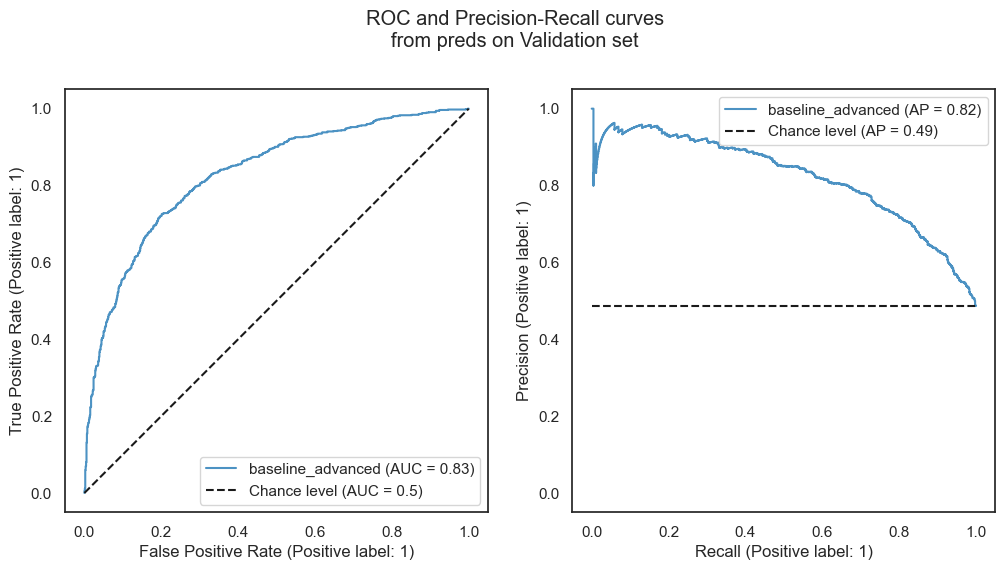

In [40]:
# create our baseline run
run_name = "baseline_advanced"

# filter mlflow.search_run dataframe on this name
query = f"tags.mlflow.runName = '{run_name}'"
results = mlflow.search_runs(experiment_names=["sentiment_analysis"], filter_string=query)

# if a run with this name does not already exist, create, fit and evaluate our baseline model
if len(results) == 0 :
    # get experiment id
    exp_id = mlflow.get_experiment_by_name("sentiment_analysis").experiment_id
    # start run
    with mlflow.start_run(experiment_id=exp_id, run_name=run_name, tags={"status": "baseline"}) :
        ## cleaning and vectorization layer
        text_vectorizer = mf.create_text_vectorizer(layer_name="text_vectorizer", vocab_size=vocab_size, sequence_len=sequence_len)
        start_time = time.time()  
        text_vectorizer.adapt(X_tr_train)
        # apply on train and validation data
        X_tr_train_vect, X_tr_valid_vect = text_vectorizer(X_tr_train), text_vectorizer(X_tr_valid)

        ## model
        model = Sequential(name=run_name)
        # add input
        model.add(Input(shape=(sequence_len,)))
        # add Embedding layer
        model.add(
            Embedding(
                input_dim=vocab_size,
                output_dim=50,
                name="embedding"
                )
            )
        # add flatten
        model.add(Flatten())
        # add Dense layers
        model.add(
            Dense(
                units=16,
                activation="relu",
                name="dense16"
            ),
            )
        # add Dense layer
        model.add(
            Dense(
                units=1,
                activation="sigmoid",
                name="dense1"
            )
            )
        # compile
        model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics=["Accuracy", "AUC"])
        model.summary()

        ## fit
        # create earlystopping
        callbacks = [
            EarlyStopping(
                monitor="val_auc",
                restore_best_weights=True,
                patience=2
            )
        ]
        # fit
        model.fit(
                x=X_tr_train_vect,
                y=y_tr_train,
                validation_data=(X_tr_valid_vect, y_tr_valid),
                callbacks=callbacks,
                epochs=10
            )

        ## metrics
        fit_time = time.time() - start_time
        _, acc, roc_auc = model.evaluate(X_tr_valid_vect, y_tr_valid)
        # log them
        mlflow.log_metric(key="valid_ROC_AUC", value=roc_auc)
        mlflow.log_metric(key="valid_Accuracy", value=acc)
        mlflow.log_metric("training_time", fit_time)

        ## plot
        # first make validation predictions (scores)
        y_val_prob = model.predict(X_tr_valid_vect)[:,0]
        # then use ploting func
        fig = mf.plotROCandPRfromTEST(
            probsList=y_val_prob, 
            namesList=run_name, 
            ytest=y_tr_valid, 
            plot_chance_level=True, 
            show=True,
            testSetName = "Validation"
            )
        # log fig
        mlflow.log_figure(figure=fig, artifact_file="valid_roc_pr_curves.png")

# else, just load the roc and pr curves
else :
    # load image artifact from mlflow experiment
    artifact_uri = results["artifact_uri"].values[0]
    roc_pr_curves = mlflow.artifacts.load_image(artifact_uri + "/valid_roc_pr_curves.png")
    # create a figure and plot
    plt.figure(figsize=(14,9))
    plt.imshow(roc_pr_curves)
    # no axis
    plt.axis(False)
    plt.show()

## P5.III) Premier essai de notre model `LSTM` bidirectionnel

Utilisons tout d'abord le pipeline complet `advanced_long_pipeline_valid` **sans** matrice d'embedding pré-entraînée, **sans** dropout et **sans** normalisation de texte :

In [18]:
# create dictionnaries with layers hyperparameters

# text vectorizer params
text_vectorizer_params = dict(
    layer_name="preprocess_vectorization_without_norm",
    lowercase=False,
    url="url", 
    email="email", 
    hashtag="hashtag", 
    mention="mension", 
    normalization=None,
    vocab_size=vocab_size, 
    sequence_len=sequence_len
)

# embedding params
embedding_params = dict(
    embedding_file_path=None,
)

# model
model_params = dict(
    model_name="no_dropout_no_pretrained_embedding", 
    seq_len=sequence_len,
    trainable_embedding=True,
    default_vocab_size = vocab_size,
    default_embedding_dim = 300,
    LSTM_units = 10, 
    LSTM_dropout = 0,
    LSTM_recurrent_dropout = 0,
    optimizer="adam",
)

# fit params
early_stopping_patience=2
fit_params = dict(
    epochs=100,
    batch_size=32,
    verbose=2,
)

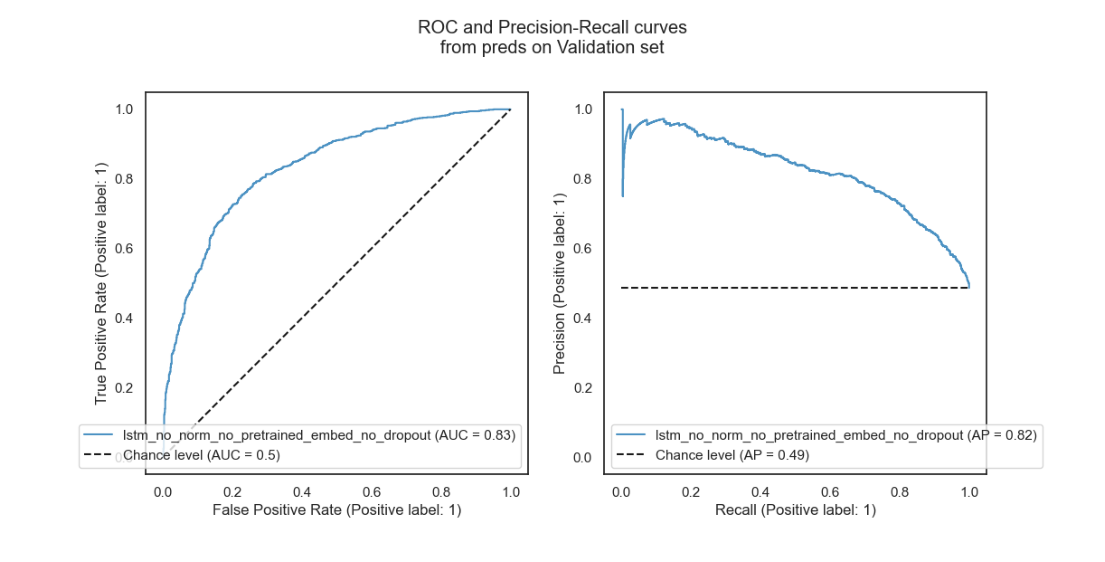

In [41]:
# use our advanced_long_pipeline_valid function with these parameters
run_name = "lstm_no_norm_no_pretrained_embed_no_dropout"

# filter mlflow.search_run dataframe on this name
query = f"tags.mlflow.runName = '{run_name}'"
results = mlflow.search_runs(experiment_names=["sentiment_analysis"], filter_string=query)

# if a run with this name does not already exist, use function advanced_long_pipeline_valid
if len(results) == 0 :
    mf.advanced_long_pipeline_valid (
        text_vectorizer_params=text_vectorizer_params, 
        embedding_params=embedding_params,
        model_params=model_params,
        run_name=run_name,
        experiment_name="sentiment_analysis",
        X_train=X_tr_train, 
        y_train=y_tr_train, 
        X_valid=X_tr_valid,
        y_valid=y_tr_valid,
        early_stopping_patience=early_stopping_patience,
        fit_params=fit_params,
        nested=False,
        outPlot = True,
        outSummary = True,
        save_time = True, 
        return_auc=False
    )

# else, just load the roc and pr curves
else :
    # load image artifact from mlflow experiment
    artifact_uri = results["artifact_uri"].values[0]
    roc_pr_curves = mlflow.artifacts.load_image(artifact_uri + "/valid_roc_pr_curves.png")
    # create a figure and plot
    plt.figure(figsize=(14,9))
    plt.imshow(roc_pr_curves)
    # no axis
    plt.axis(False)
    plt.show()


## P5.IV) Quelle normalisation ?

Testons maintenant l'impact de **`normalization = "stem"`** ou **`normalization = "lem"`**

Nota : Nous allons également injecter des vecteurs mots pré-entraînés ("glove.twitter.27B.50d.txt", non entraînable) dans le pipeline. En effet il est important de comparer `stem` et `lem` dans une situation plus proche de la version finale.

In [ ]:
# test normalization = "stem" or "lem"
for norm in ["stem", "lem"] :
    # update text_vectorizer_params
    text_vectorizer_params["layer_name"] = "preprocess_vectorization_"+norm
    text_vectorizer_params["normalization"] = norm

    # update embedding params
    embedding_params["embedding_file_path"] = "pretrained_embeddings/glove.twitter.27B.50d.txt"
    model_params["trainable_embedding"] = False

    # run name
    run_name = "norm_exploration_"+norm

    # filter mlflow.search_run dataframe on this name
    query = f"tags.mlflow.runName = '{run_name}'"
    results = mlflow.search_runs(experiment_names=["sentiment_analysis"], filter_string=query)

    # if a run with this name does not already exist, use function advanced_long_pipeline_valid
    if len(results) == 0 :
        mf.advanced_long_pipeline_valid (
            text_vectorizer_params=text_vectorizer_params, 
            embedding_params=embedding_params,
            model_params=model_params,
            run_name=run_name,
            experiment_name="sentiment_analysis",
            X_train=X_tr_train, 
            y_train=y_tr_train, 
            X_valid=X_tr_valid,
            y_valid=y_tr_valid,
            early_stopping_patience=early_stopping_patience,
            fit_params=fit_params,
            nested=False,
            outPlot = True,
            outSummary = True,
            save_time = True, 
            return_auc=False
        )
    
    # else, just load the roc and pr curves
    else :
        # load image artifact from mlflow experiment
        artifact_uri = results["artifact_uri"].values[0]
        roc_pr_curves = mlflow.artifacts.load_image(artifact_uri + "/valid_roc_pr_curves.png")
        # create a figure and plot
        plt.figure(figsize=(14,9))
        plt.imshow(roc_pr_curves)
        # no axis
        plt.axis(False)
        plt.show()


In [ ]:
# get mlflow results
results = mlflow.search_runs(experiment_names=["sentiment_analysis"])
# filter on runs
mask = results["tags.mlflow.runName"].apply(lambda x : "norm_exploration_" in x)
# columns
cols = ["tags.mlflow.runName", "metrics.valid_ROC_AUC", "metrics.valid_Accuracy", "metrics.training_time", "params.normalization"]
results.loc[mask, cols]

Nous choisissons la ***lemmatisation***, qui nous offre une meilleure `ROC_AUC` sur les données de validation.

In [ ]:
text_vectorizer_params["normalization"] = "lem"
text_vectorizer_params["layer_name"] = "preprocess_vectorization_lem"

## P5.V) Quel embedding ?

Essayons maintenant deux fichiers de *"vecteurs mots"* :
- Glove : `glove.6B.300d.txt`
- FastText : `fasttext-wiki-news-300d-1M.vec`


et comparons les résultats :

In [ ]:
# test Glove or FastText
for trainable_embedding in [False, True] :
    for name,path in zip(["Glove", "fastText"],["pretrained_embeddings/glove.6B.300d.txt", "pretrained_embeddings/fasttext-wiki-news-300d-1M.vec"]) :
        # update embedding params
        embedding_params["embedding_file_path"] = path
        # update model params
        model_params["model_name"] = "no_dropout_"+name+"_embedding"+"_"+str(trainable_embedding)
        model_params["trainable_embedding"] = trainable_embedding
    
        # run name
        run_name = "embedding_exploration_"+name+"_"+str(trainable_embedding)
    
        # filter mlflow.search_run dataframe on this name
        query = f"tags.mlflow.runName = '{run_name}'"
        results = mlflow.search_runs(experiment_names=["sentiment_analysis"], filter_string=query)
    
        # if a run with this name does not already exist, use function advanced_long_pipeline_valid
        if len(results) == 0 :
            mf.advanced_long_pipeline_valid (
                text_vectorizer_params=text_vectorizer_params, 
                embedding_params=embedding_params,
                model_params=model_params,
                run_name=run_name,
                experiment_name="sentiment_analysis",
                X_train=X_tr_train,#.iloc[:1000], 
                y_train=y_tr_train,#.iloc[:1000], 
                X_valid=X_tr_valid,#.iloc[:100],
                y_valid=y_tr_valid,#.iloc[:100],
                early_stopping_patience=early_stopping_patience,
                fit_params=fit_params,
                nested=False,
                outPlot=True,
                outSummary=True,
                save_time=True, 
                return_auc=False
            )
        
        # else, just load the roc and pr curves
        else :
            # load image artifact from mlflow experiment
            artifact_uri = results["artifact_uri"].values[0]
            roc_pr_curves = mlflow.artifacts.load_image(artifact_uri + "/valid_roc_pr_curves.png")
            # create a figure and plot
            plt.figure(figsize=(14,9))
            plt.imshow(roc_pr_curves)
            # no axis
            plt.axis(False)
            plt.show()


In [ ]:
# get mlflow results
results = mlflow.search_runs(experiment_names=["sentiment_analysis"])
# filter on runs
mask = results["tags.mlflow.runName"].apply(lambda x : "embedding_exploration_" in x)
# columns
cols = ["tags.mlflow.runName", "metrics.valid_ROC_AUC", "metrics.valid_Accuracy", "metrics.training_time", "params.normalization"]
results.loc[mask, cols]

Nous choisissons ***FastText*** avec des **poids entraînables**, qui nous offre une meilleure `ROC_AUC` sur les données de validation.

In [ ]:
# update embedding params
embedding_params["embedding_file_path"] = "pretrained_embeddings/glove.6B.300d.txt"
# update model params
model_params["model_name"] = "no_dropout_glove_embedding"
model_params["trainable_embedding"] = True

## P5.VI) Quels hyperparamètres pour le modèle `LSTM` ?

Maintenant que nous avons choisi les hyperparamètres des étapes préliminaires de notre pipeline, nous pouvons nous intéresser :
- au modèle `LSTM` (`LSTM_units`, `LSTM_dropout`, `LSTM_recurrent_dropout`, `optimizer`)
- aux paramètres d'entraînement (`early_stopping_patience`, `batch_size`)

Nota : il n'y a que 2 éléments dans les listes comportant des nombres entiers ou des nombres flottants, `optuna` choisira des valeurs comprises entre ces 2 nombres, avec un pas égal au plus petit : `trial.suggest_int(name=param, low=min(listOfValues), high=max(listOfValues), step=min(listOfValues))`.

In [ ]:
run_name_prefix = "optuna_advanced"

# create dictionnaries with layers hyperparameters grids

# model GRID
model_params_grid = dict(
    model_name = "LSTM_for_"+run_name_prefix,
    seq_len=sequence_len,
    LSTM_units = [10, 40], 
    LSTM_dropout = [0.2, 0.8],
    LSTM_recurrent_dropout = [0.2, 0.8],
    optimizer = ["adam","RMSprop"],
    trainable_embedding = True,
)

# fit params
early_stopping_patience_grid=[4, 6]

fit_params_grid = dict(
    epochs=100,
    batch_size=[32,128],
    verbose=0,
)

In [ ]:
# filter mlflow.search_run dataframe on this name
query = f"tags.mlflow.runName = '{run_name_prefix}_PARENT'"
results = mlflow.search_runs(experiment_names=["sentiment_analysis"], filter_string=query)

# if a run with this name does not already exist, use function
if len(results) == 0 :
    mf.optunaShortAdvanced(
        text_vectorizer_params=text_vectorizer_params,
        embedding_params=embedding_params,
        model_params_grid=model_params_grid,
        run_name_prefix=run_name_prefix,
        experiment_name="sentiment_analysis",
        X_train=X_tr_train,#[:1000], 
        y_train=y_tr_train,#[:1000], 
        X_valid=X_tr_valid,#[:100],
        y_valid=y_tr_valid,#[:100],
        early_stopping_patience_grid=early_stopping_patience_grid,
        fit_params_grid=fit_params_grid,
        n_trials=30,
        save_time=True
    )


# else, just load the roc and pr curves
else :
    # load image artifact from mlflow experiment
    artifact_uri = results["artifact_uri"].values[0]
    roc_pr_curves = mlflow.artifacts.load_image(artifact_uri + "/valid_roc_pr_curves.png")
    # create a figure and plot
    plt.figure(figsize=(14,9))
    plt.imshow(roc_pr_curves)
    # no axis
    plt.axis(False)
    plt.show()

Regardons les résultats :

In [ ]:
# get mlflow results
results = mlflow.search_runs(experiment_names=["sentiment_analysis"])
# filter on runs
mask = results["tags.mlflow.runName"].apply(lambda x : "optuna_advanced" in x)
# columns
cols = ["tags.mlflow.runName", "metrics.valid_ROC_AUC", "metrics.valid_Accuracy", "metrics.training_time", "params.normalization"]
# cols = cols+[col for col in results.columns if "params." in col]

display(results.loc[mask, cols])

Nous pouvons du coup extraire les meilleurs hyperparamètres pour notre modèle avancé :

In [ ]:
# extract best hyperparamters and put them in dictionaries

# first focus on "params." columns and on the "PARENT" run
cols = [col for col in results.columns if "params." in col]
mask = results["tags.mlflow.runName"] == "optuna_advanced_PARENT"
best_parameters = results.loc[mask, cols]
# rename columns (remove "params.")
best_parameters = best_parameters.rename(columns={col:col.split("params.")[-1] for col in best_parameters})

# put parameters in a dict
best_parameters = best_parameters.iloc[0].to_dict()
# carefull with numericals (mlflow logs numbers as string)
best_parameters = {param : int(val) if (type(val) == str and val.isnumeric()) else val for param, val in best_parameters.items()}
best_parameters = {param : float(val)  if (type(val) == str and val.replace(".", "").isnumeric()) else val for param, val in best_parameters.items()}
# carefull with bools
best_parameters = {param : True if val == "True" else val for param, val in best_parameters.items()}
best_parameters = {param : False if val == "False" else val for param, val in best_parameters.items()}

# use inspect to get functions' parameters names
import inspect
# initiate dictionnaries for our training pipeline
best_text_vectorizer_params = {}
best_embedding_params = {}
best_model_params = {}
# for each function and parameters dictionary
for paramsDict, func in zip(
    [best_text_vectorizer_params, best_embedding_params, best_model_params],
    [mf.create_text_vectorizer, mf.get_embedding_matrix, mf.create_LSTM]
) :
    # get the list of parameters
    argspec = inspect.getfullargspec(func).args
    if len(argspec) > 0 :
        paramsList = argspec
    else :
        # model.fit does not give its parameters, we just keep "epochs", "batch_size", "verbose", already given
        paramsList = list(paramsDict.keys())
    # complete the dictionaries    
    for param in paramsList :
        if (param in best_parameters) and (param not in  ["verbose"]) :
            paramsDict[param] = best_parameters[param]

# get fit_params
best_fit_params = {"batch_size" : best_parameters["batch_size"], "epochs" : 100, "verbose" : 2}

# get early_stopping_patience
best_early_stopping_patience = best_parameters["early_stopping_patience"]


# print results
print("best_text_vectorizer_params :")
print(best_text_vectorizer_params)
print("best_embedding_params :")
print(best_embedding_params)
print("best_model_params :")
print(best_model_params)
print("best_early_stopping_patience :")
print(best_early_stopping_patience)
print("best_fit_params :")
print(best_fit_params)

## P5.VII) Modèle avancé final

In [ ]:
# create folders to save advanced model
if not os.path.isdir("mySaves/advanced_model_large"):
    os.mkdir("mySaves/advanced_model_large")

In [ ]:
# use our advanced_long_pipeline_valid function with these parameters
run_name = "final_advanced"
best_model_params["model_name"] = run_name

# filter mlflow.search_run dataframe on this name
query = f"tags.mlflow.runName = '{run_name}'"
results = mlflow.search_runs(experiment_names=["sentiment_analysis"], filter_string=query)

# if a run with this name does not already exist, use function advanced_long_pipeline_valid
if len(results) == 0 :
    # TEXT_VECT, MODEL, MODEL_EXP=
    mf.advanced_long_pipeline_test (
        text_vectorizer_params=best_text_vectorizer_params,
        embedding_params=best_embedding_params,
        model_params=best_model_params,
        run_name=run_name,
        experiment_name="sentiment_analysis",
        X_train=X_tr_train,#[:100], 
        y_train=y_tr_train,#[:100], 
        X_valid=X_tr_valid,#[:10],
        y_valid=y_tr_valid,#[:10],
        X_test=X_test,#[:10],
        y_test=y_test,#[:10],
        early_stopping_patience = best_early_stopping_patience,
        fit_params=best_fit_params,
        outPlot=True, 
        outSummary=True,
        save_time=True, 
        save_model=True,
        save_path="mySaves/advanced_model_large/",
        tagStatus="final"
    )


# else, just load the roc and pr curves
else :
    # load image artifact from mlflow experiment
    artifact_uri = results["artifact_uri"].values[0]
    roc_pr_curves = mlflow.artifacts.load_image(artifact_uri + "/test_roc_pr_curves.png")
    # create a figure and plot
    plt.figure(figsize=(14,9))
    plt.imshow(roc_pr_curves)
    # no axis
    plt.axis(False)
    plt.show()


## P5.VII) Modèle avancé final SMALL

In [ ]:
# use our advanced_long_pipeline_valid function with these parameters
run_name = "final_advanced_SMALL"
best_model_params["model_name"] = run_name

# filter mlflow.search_run dataframe on this name
query = f"tags.mlflow.runName = '{run_name}'"
results = mlflow.search_runs(experiment_names=["sentiment_analysis"], filter_string=query)

# if a run with this name does not already exist, use function advanced_long_pipeline_valid
if len(results) == 0 :
    mf.advanced_long_pipeline_test (
        text_vectorizer_params=best_text_vectorizer_params,
        embedding_params=best_embedding_params,
        model_params=best_model_params,
        run_name=run_name,
        experiment_name="sentiment_analysis",
        X_train=X_tr_train[:100], 
        y_train=y_tr_train[:100], 
        X_valid=X_tr_valid[:10],
        y_valid=y_tr_valid[:10],
        X_test=X_test[:10],
        y_test=y_test[:10],
        early_stopping_patience = best_early_stopping_patience,
        fit_params=best_fit_params,
        outPlot=True, 
        outSummary=True,
        save_time=True, 
        save_model=True,
        save_path="mySaves/advanced_model_large/",
        tagStatus="final"
    )


# else, just load the roc and pr curves
else :
    # load image artifact from mlflow experiment
    artifact_uri = results["artifact_uri"].values[0]
    roc_pr_curves = mlflow.artifacts.load_image(artifact_uri + "/test_roc_pr_curves.png")
    # create a figure and plot
    plt.figure(figsize=(14,9))
    plt.imshow(roc_pr_curves)
    # no axis
    plt.axis(False)
    plt.show()


# PARTIE 6 - MODELE BERT

## P6.I) Méthode

### P6.I.1) BERT ?

**BERT** (Bidirectional Encoder Representations from Transformers) est un modèle de traitement automatique du langage naturel (NLP) préentraîné publié en 2018 par Google. Il utilise une **architecture de transformeur bidirectionnel** pour générer des représentations de mots dans leur **contexte**, améliorant ainsi les performances sur une variété de tâches NLP telles que la classification de texte, l'extraction d'informations et la compréhension de questions.


Avant BERT, les approches courantes en NLP impliquaient souvent des fonctionnalités spécifiques à la tâche ou des architectures dédiées, ce qui limitait leurs capacités à se généraliser sur des tâches plus variées. Avec sa **formation massive sur un corpus de données textuelles diversifié** et son transfert efficace vers **différentes tâches NLP**, BERT a **considérablement amélioré l'état de l'art et établi de nouvelles normes en matière de performance dans le domaine du NLP**.

1. **Architecture de transformateur** : BERT s'appuie sur l'architecture de transformateur introduite dans **"Attention is All You Need"** pour capturer les relations entre les mots dans un contexte plus large. Cela permet au modèle de comprendre les **nuances subtiles du langage humain** grâce aux mécanismes d'attention multi-têtes.
2. **Apprentissage bidirectionnel** : Contrairement aux modèles précédents qui ne peuvent apprendre qu'un seul côté du contexte (gauche ou droit), BERT adopte une **approche bidirectionnelle lors de l'encodage des entrées**. Cette technique permet au modèle de mieux comprendre les interactions complexes entre les mots et leur signification dans un contexte particulier.
3. **Pré-entrapinement** : Avant d'être appliqués à des tâches spécifiques, BERT a été formé sur un **corpus énorme provenant du web, d'articles, de livres, etc**. Il est donc capable d'adapter les interactions entre les mots en fonction du contexte de façon très précise.
4. **Transfer learning** : Après le pré-entraînement, les poids du modèle BERT peuvent être **utilisés comme point de départ pour une grande variété de tâches NLP**, y compris sur de l'apprentissage supervisé ! Ce processus de **fine tuning** permet au modèle de tirer parti des connaissances acquises précédemment pour réaliser des **performances exceptionnelles avec relativement peu de données annotées**.
5. **Flexibilité** : Grâce à ses conceptions flexibles, BERT peut être adapté à plusieurs formats de séquences d'entrée, notamment des phrases isolées, des paires de phrases et même des documents entiers. De plus, il existe des versions de taille variable de BERT, offrant un compromis entre la précision et les ressources informatiques requises.
6. **Impact** : Depuis sa publication en 2018, BERT a eu un **impact significatif sur le paysage NLP**, battant régulièrement les records de performance sur divers benchmarks et devenant rapidement la **base de nombreuses applications pratiques dans l'industrie et la recherche universitaire**. Les idées clés derrière BERT ont également inspiré de nombreuses autres innovations en NLP, telles que GPT.

### P6.I.2) Quel serait l'apport d'un modèle BERT pour le projet ?

Nous allons tester un modèle de type BERT pour juger de son apport en termes de performance :
- utilisation de la librairie `transformers` fournie par **Hugging Face**
- utilisation d'un modèle pré-entraîné **léger** : https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english

    *"This model is a fine-tune checkpoint of DistilBERT-base-uncased, fine-tuned on SST-2. This model reaches an accuracy of 91.3 on the dev set (for comparison, Bert bert-base-uncased version reaches an accuracy of 92.7). **DistilBERT is a transformers model, smaller and faster than BERT**, which was pretrained on the same corpus in a self-supervised fashion, using the BERT base model as a teacher."*

Nous utiliserons les réglages suivants :
- `tokenizer` :
    - `padding = True`
    - `truncation = True`
    - `return_tensors = "tf"`
- `config` du model :
    - `id2label = {"0" : "POSITIVE" , "1" : "NEGATIVE"}` (et non pas `{"0" : "NEGATIVE" , "1" : "POSITIVE"}`), pour refléter la réglage effectué lors du chargement des données.
    - idem pour `label2id`
    - `config.attention_dropout = 0.4`
    - `config.dropout = 0.4`
    - `config.seq_classif_dropout = 0.4`
- `optimizer=Adam(learning_rate=3e-5)`, cf. https://huggingface.co/docs/transformers/training : *"# Lower learning rates are often better for fine-tuning transformers"*
- `EarlyStopping` avec une patience de 2


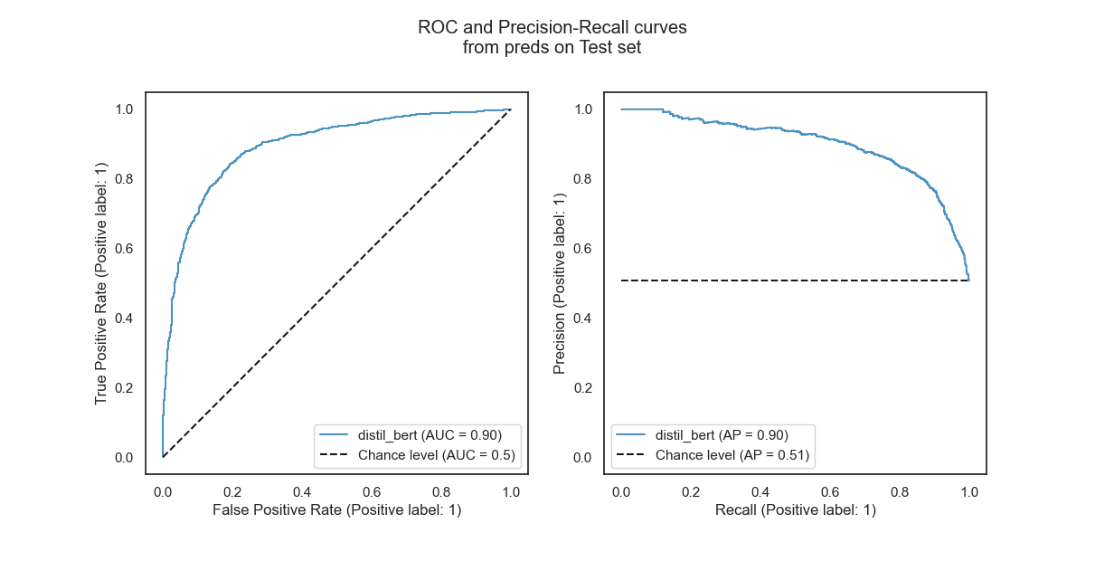

In [6]:
# use our advanced_long_pipeline_valid function with these parameters
run_name = "distil_bert"

# filter mlflow.search_run dataframe on this name
query = f"tags.mlflow.runName = '{run_name}'"
results = mlflow.search_runs(experiment_names=["sentiment_analysis"], filter_string=query)

# if a run with this name does not already exist, use function advanced_long_pipeline_valid
if len(results) == 0 :
    mf.transformer_pipe_test(
        pretrained_model_name_or_path="distilbert/distilbert-base-uncased-finetuned-sst-2-english",
        run_name=run_name,
        experiment_name="sentiment_analysis",
        X_train=X_tr_train,#[:100], 
        y_train=y_tr_train,#[:100], 
        X_valid=X_tr_valid,#[:10],
        y_valid=y_tr_valid,#[:10],
        X_test=X_test,#[:10],
        y_test=y_test,#[:10],
        early_stopping_patience = 2,
        fit_params = {
            "epochs":10, 
            "batch_size":128
            },
        outPlot=True, 
        outSummary=True,
        save_time=True, 
        tagStatus="test_BERT"
    )


# else, just load the roc and pr curves
else :
    # load image artifact from mlflow experiment
    artifact_uri = results["artifact_uri"].values[0]
    roc_pr_curves = mlflow.artifacts.load_image(artifact_uri + "/test_roc_pr_curves.png")
    # create a figure and plot
    plt.figure(figsize=(14,9))
    plt.imshow(roc_pr_curves)
    # no axis
    plt.axis(False)
    plt.show()

Les résultats sont encore meilleurs !

# PARTIE 7 - USE

Nous pouvons également tester également l'*Universal Sentence Encoder*, une solution non pas de *word embedding*, mais de ***sentence** embedding*. Cette architecture, également développée par Google, est plus ancienne que le modèle *BERT*. 

Elle reste très intéressante néanmoins car moins consommatrice de ressources mémoire. 

Nous allons utiliser la librairie `Tensorflow_hub` pour charger la couche d'embedding pré-entrainée `"https://tfhub.dev/google/universal-sentence-encoder/4"`. Cela nous permettra d'utiliser *USE* pour faire du *Transfer Learning*. Le modèle contruit est alors constitué de :
- notre couche d'embedding `USE` pré-entraînée, que nous allons *fine-tuner* (`trainable=True`)
- une couche de `Dropout`
- une couche `Dense` de 16 neurones
- une couche `Dense` de 1 neurone

507/507 [==============================] - 473s 913ms/step - loss: 0.4974 - Accuracy: 0.7638 - auc: 0.8392 - val_loss: 0.4811 - val_Accuracy: 0.7817 - val_auc: 0.8691
Model: "USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense16 (Dense)             (None, 16)                8208      
                                                                 
 dense1 (Dense)              (None, 1)                 17        
                                                                 
Total params: 256806049 (979.64 MB)
Trainable params: 256806049 (979.64 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________

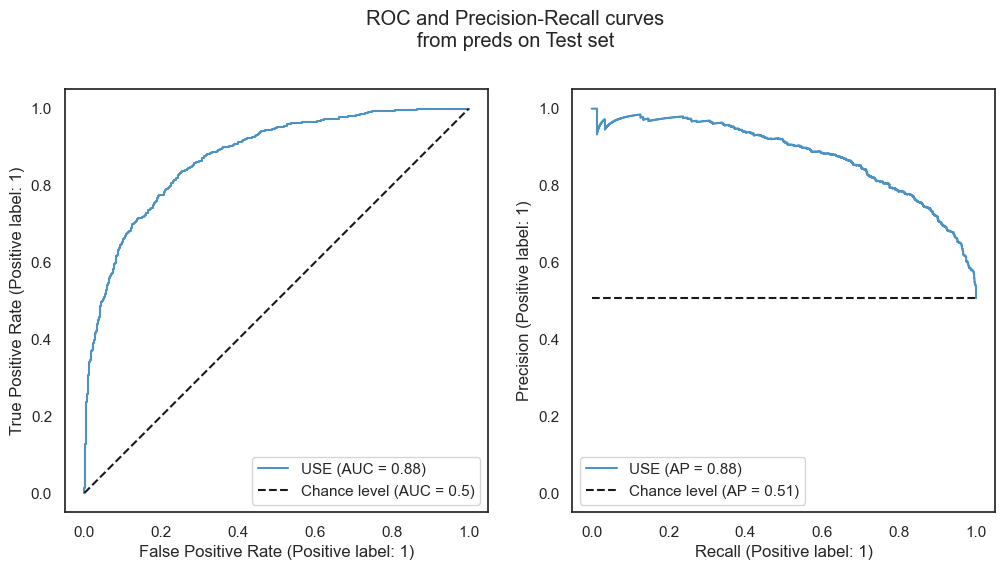

In [50]:
# create our baseline run
run_name = "USE"

# filter mlflow.search_run dataframe on this name
query = f"tags.mlflow.runName = '{run_name}'"
results = mlflow.search_runs(experiment_names=["sentiment_analysis"], filter_string=query)

# if a run with this name does not already exist, create, fit and evaluate our baseline model
if len(results) == 0 :
    mf.use_pipe_test(
        run_name=run_name,
        experiment_name="sentiment_analysis",
        X_train=X_tr_train,#[:100], 
        y_train=y_tr_train,#[:100], 
        X_valid=X_tr_valid,#[:10],
        y_valid=y_tr_valid,#[:10],
        X_test=X_test,#[:10],
        y_test=y_test,#[:10],
        early_stopping_patience = 2,
        fit_params = {
            "epochs":10, 
            "batch_size":64
            },
        outPlot=True, 
        outSummary=True,
        save_time=True, 
        tagStatus="test_USE"
    )

# else, just load the roc and pr curves
else :
    # load image artifact from mlflow experiment
    artifact_uri = results["artifact_uri"].values[0]
    roc_pr_curves = mlflow.artifacts.load_image(artifact_uri + "/valid_roc_pr_curves.png")
    # create a figure and plot
    plt.figure(figsize=(14,9))
    plt.imshow(roc_pr_curves)
    # no axis
    plt.axis(False)
    plt.show()

Le résultat est là aussi intéressant !

# PARTIE 8 - UTILISER LE MODELE AVANCÉ

Testons les fonctionnalités de `mlflow` pour utiliser notre modèle avancé :

## P8.1) Le charger depuis `mlflow`

Nous allons tout d'abord utiliser le modèle *loggé* dans le `/mlruns`. Pour cela nous avons créé une fonction `load_mlflow_advanced_model` :
- filtrer sur le `run_name`
- charger les arguments et la fonction `custom_standardize` 
    
    Nota : en effet pour pouvoir être chargée avec `Keras` sans créer d'erreur, une classe ou une fonction (dans notre cas, la fonction `custom_standardize`) a besoin d'être créée avec le *decorator* `@keras.saving.register_keras_serializable()`.
- charger le modèle avec `mlflow.tensorflow.load_model`
    

In [2]:
# load "final_advanced" using custom function "load_mlflow_advanced_model"
loaded_advanced_model = mf.load_mlflow_advanced_model(run_name="final_advanced", experiment_name="sentiment_analysis", from_registry=False)

# summaries
loaded_advanced_model.summary()
loaded_advanced_model.layers[1].summary()



Nous pouvons maintenant l'utiliser :

In [3]:
# test our loaded_advanced_model
X = ["I hate you","I love you", "I thought I would love you but I don't"]
X = tf.convert_to_tensor(X)
mf.predict_with_loaded_model(loaded_advanced_model, X, proba = False)

1/1 [==============================] - 0s 473ms/step


array([1, 0, 1])

Vérifions que la `roc_auc` est bien la même sur le set de test :

In [12]:
# compare roc auc, logged VS computed woth loaded model
run_name = "final_advanced"

# logged with mlflow
# filter mlflow.search_run dataframe on this name
query = f"tags.mlflow.runName = '{run_name}'"
results = mlflow.search_runs(experiment_names=["sentiment_analysis"], filter_string=query)
# print looged roc auc on test set 
print("ROC AUC on Test set, logged :")
print(round(results["metrics.test_ROC_AUC"].values[0],4))

# with loaded model
scores_test = mf.predict_with_loaded_model(loaded_advanced_model, X_test, proba = True)
print("ROC AUC on Test set, with loaded model :")
print(round(roc_auc_score(y_test, scores_test),4))

ROC AUC on Test set, logged :
0.8676
63/63 [==============================] - 0s 6ms/step
ROC AUC on Test set, with loaded model :
0.8676


## P8.2) Test du service de *serving* `mlflow`

- Via la ligne de commande :
    - se placer dans le dossier contenant */mlruns*
    - `mlflow models serve -m "models:/final_advanced_export/1" -p 1234 --no-conda`
- puis tester l'API grâce à la librairie `requests` :

In [15]:
import requests

inference_request = {
    "inputs" : ["I hate humans", "I love humans", "I say I love humans but it's not true"] 
}

endpoint = "http://127.0.0.1:1234/invocations"

response = requests.post(endpoint, json=inference_request)

print(response.text)

{"predictions": [[0.9499937295913696], [0.11322450637817383], [0.9079648852348328]]}


# Annexe - effacer les runs

`mlflow` garde sur le disque les runs effacés via l'`ui` ou via `mlflow.delete_run`. Pour y accéder nous pouvons renseigner `run_view_type=2` dans `mlflow.search_runs`. Bien qu'essentiel pour ne pas perdre d'information, nous allons pour notre cas les effacer :

In [51]:
# get all deleted (run_view_type=2) mlflow results
pathsToRemove = mlflow.search_runs(experiment_names=["sentiment_analysis"], run_view_type=2)

# focus on uri paths
pathsToRemove = pathsToRemove['artifact_uri']
# remove '/artifacts' from paths
pathsToRemove = pathsToRemove.apply(lambda x : re.sub(r"(/artifacts)", "", x))
# remove all characters until "mlrun/"
# https://stackoverflow.com/questions/7124778/how-can-i-match-anything-up-until-this-sequence-of-characters-in-a-regular-exp
pathsToRemove = pathsToRemove.apply(lambda x : re.sub(r".+?(?=mlruns/)", "", x))
print(len(pathsToRemove))
# remove directories using shutil
for path in pathsToRemove.values :
    shutil.rmtree(path, ignore_errors=False)

6
